<a href="https://colab.research.google.com/github/Abdelrahman898/COVID-19-Dashboard/blob/main/Copy_of_titanic_prediction_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic prediction

- survival	Survival	0 = No, 1 = Yes
- pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- sex	Sex	
- Age	Age in years	
- sibsp	 of siblings / spouses aboard the Titanic	
- parch	 of parents / children aboard the Titanic	
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

pclass: A proxy for socio-economic status (SES):
-       1st = Upper
-       2nd = Middle
-       3rd = Lower

age: 
-       Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: 
-       The dataset defines family relations in this way...
    Sibling 
    - brother, sister, stepbrother, stepsister
    Spouse 
    - husband, wife (mistresses and fiancés were ignored)

parch:
-       The dataset defines family relations in this way...
    Parent 
    - mother, father
    Child 
    - daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them

# Import libraries

In [ ]:
!pip install mlens


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 KB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.9 MB/s eta 0:00:00


In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning library
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import optuna
from optuna.samplers import TPESampler
import mlens
from mlens.ensemble import SuperLearner


[MLENS] backend: threading


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic proj/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic proj/test.csv')

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Data Preprocessing

In [ ]:
train_df["LastName"] = train_df["Name"].apply(lambda x : x.split(" ")[0]).str.split(",", expand=True)[0]
test["LastName"] = test["Name"].apply(lambda x : x.split(" ")[0]).str.split(",", expand=True)[0]

df = pd.concat([train_df, test])

survive = []
died = []

for index, row in df.iterrows():
    sur = df[(df["LastName"] == row["LastName"]) & (df["Survived"] == 1)]
    d = df[(df["LastName"] == row["LastName"]) & (df["Survived"] == 0)]
    
    sur = len(sur)
    if row["Survived"] == 1:
        sur -= 1
    
    d = len(d)
    if row["Survived"] == 0:
        d -= 1
    
    survive.append(sur)
    died.append(d)
    
df["FamilySurvived"] = survive
df["FamilyDied"] = died



In [ ]:
def cleaner(df):
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    df['Title'] = df['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df["Title"] = df["Title"].map({"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, "Mrs": 1, "Mr": 2, "Rare": 3})
    df["Title"] = df["Title"].astype(int)

cleaner(df)


<ipython-input-8-9346cd3c35df>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['IsAlone'].loc[df['FamilySize'] > 1] = 0


In [ ]:
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()]
test = test.drop(['Survived'], axis=1)

print(train.shape)
print(test.shape)

(891, 18)
(418, 17)


# Feature Engineering

In [ ]:
# let's create a new feature rich_female and poor_male.
train["rich_female"] = 0
test["rich_female"] = 0
train["poor_male"] = 0
test["poor_male"] = 0

# here we define the rich_female with class 1 or 2 and give it a value of 1, otherwise 0.
train.loc[(train["Pclass"] <= 2) & (train["Sex"] == "female"), "rich_female"] = 1
test.loc[(test["Pclass"] <= 2) & (test["Sex"] == "female"), "rich_female"] = 1
train["rich_female"] = train["rich_female"].astype(int)
test["rich_female"] = test["rich_female"].astype(int)


# here we define the poor_male with class 3 and give it a value of 1, otherwise 0.
train.loc[(train["Pclass"] == 3) & (train["Sex"] == "male"), "poor_male"] = 1
test.loc[(test["Pclass"] == 3) & (test["Sex"] == "male"), "poor_male"] = 1
train["poor_male"] = train["poor_male"].astype(int)
test["poor_male"] = test["poor_male"].astype(int)


<ipython-input-10-245f6a644d49>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["rich_female"] = 0
<ipython-input-10-245f6a644d49>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["poor_male"] = 0
<ipython-input-10-245f6a644d49>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [ ]:
# let's replacing missing values in the Cabin column with 'X' and extracting the first character of non-missing values.
train["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in train["Cabin"])
test["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in test["Cabin"])

<ipython-input-11-42fc6c91a040>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Cabin"] = pd.Series(i[0] if not pd.isnull(i) else 'X' for i in train["Cabin"])


In [ ]:
# let's encode the categorical features.
for cat in ['Pclass', 'Sex', 'Embarked', 'Cabin']:
    train = pd.concat([train, pd.get_dummies(train[cat], prefix=cat)], axis=1)
    train = train.drop([cat], axis=1)
    
    test = pd.concat([test, pd.get_dummies(test[cat], prefix=cat)], axis=1)
    test = test.drop([cat], axis=1)
        


In [ ]:
# let's drop the unnecessary columns.
train = train.drop(['PassengerId', 'Ticket', 'LastName', 'SibSp', 'Parch','Name'], axis=1)
test = test.drop(['PassengerId', 'Ticket', 'LastName', 'SibSp', 'Parch','Name'], axis=1)

In [ ]:
train.isnull().sum()
test.isnull().sum()

Age               0
Fare              0
FamilySurvived    0
FamilyDied        0
FamilySize        0
IsAlone           0
Title             0
rich_female       0
poor_male         0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Sex_female        0
Sex_male          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Cabin_A           0
Cabin_B           0
Cabin_C           0
Cabin_D           0
Cabin_E           0
Cabin_F           0
Cabin_G           0
Cabin_X           0
dtype: int64

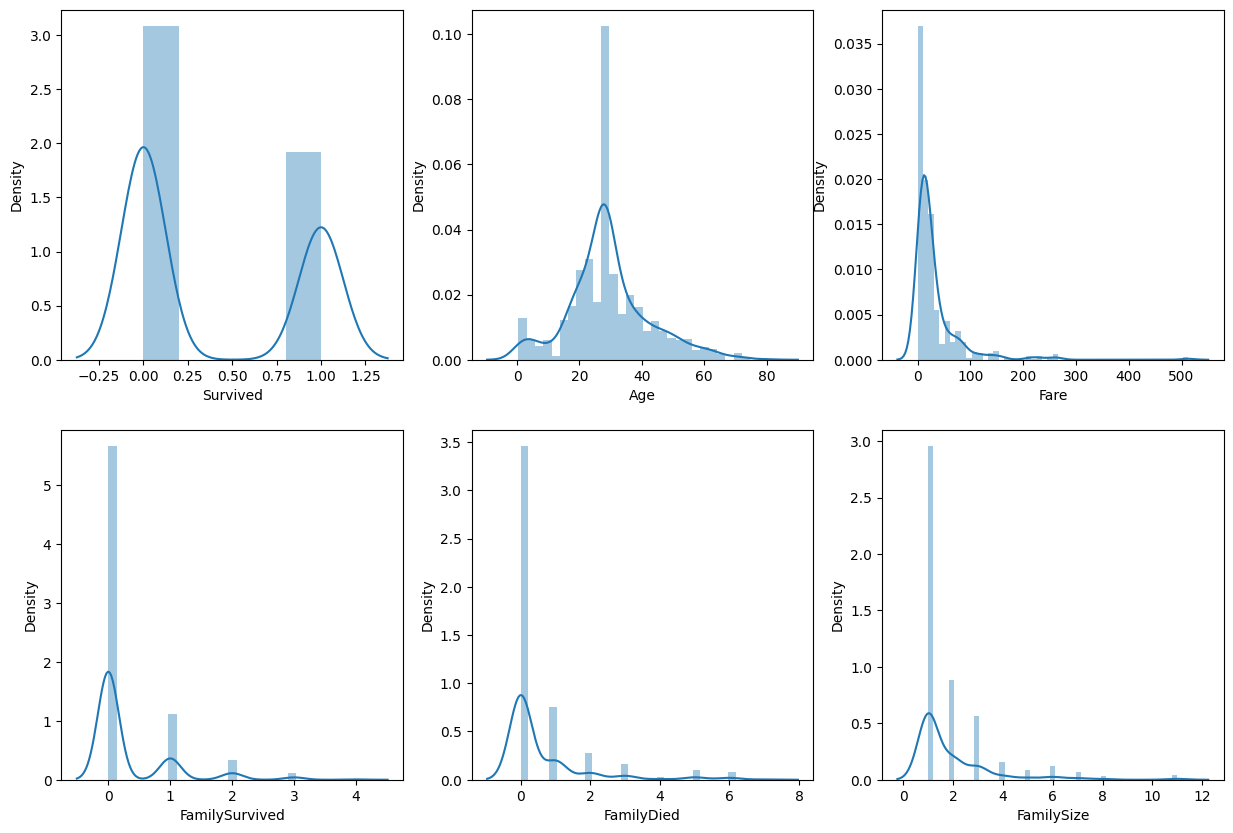

In [ ]:
def plot_hist(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for col in df.columns:
        if df[col].dtype in numeric_dtypes:
            numeric.append(col)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for axes, col in zip(axes.flatten(), df[numeric]):
        sns.distplot(df[col], ax=axes, kde=True)
        
plot_hist(train)

In [ ]:
def skewed_features(df):
    column = ["Age", "Fare"]
    for col in df[column]:
        df[col] = np.log1p(df[col])
            
skewed_features(train)
skewed_features(test)

# Model Building

### Splitting the data.

In [ ]:
X = train.drop(['Survived', 'Cabin_T'], axis=1)   # we drop 'Cabin_T' so i can made prediction cuz it's not representing in test set.
y = train['Survived']

import copy
test_df = copy.copy(test)

In [ ]:
# let's split the data.
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")

x_train shape: (712, 25)
y_train shape: (712,)
x_val shape: (179, 25)
y_val shape: (179,)


### Single models training and optimization

- we 'll use optuna framework to optimize the hyperparameters of the models.


In [ ]:
"""
The TPESampler:
    is a class in the optuna library that implements the Tree-structured Parzen Estimator (TPE) algorithm for hyperparameter optimization.
    The TPE algorithm is a Bayesian optimization method that fits two Gaussian Mixture Models (GMMs)
    to the set of parameter values associated with the best and worst objective values. It then chooses the parameter value that maximizes the ratio of the two GMMs.
    The TPESampler class provides an interface for using the TPE algorithm in optuna studies to suggest hyperparameter values for each trial.
"""
class Optimizer:
    def __init__(self, metric, trials=30):
        self.metric = metric
        self.trials = trials
        self.sampler = TPESampler(seed=42)
        
    def objective(self, trial):
        model = create_model(trial)  # which we 'll define later.
        model.fit(x_train, y_train)
        pred = model.predict(x_val)
        if self.metric == "accuracy" or "acc":
            score = accuracy_score(y_val, pred)
            return score
        elif self.metric == "f1" or "f1_score":
            return f1_score(y_val, pred)
        else:
            raise ValueError("Please enter a valid metric.")
    
    def optimize(self):
        study = optuna.create_study(direction="maximize", sampler=self.sampler, study_name="TPE")
        study.optimize(self.objective, n_trials=self.trials)
        return study.best_params
    

#### 1.RandomForestClassifier 

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
pred = rf.predict(x_val)

print(f"Random Forest Classifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Random Forest Classifier F1 Score: {f1_score(y_val, pred)}")


def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 500)
    max_depth = trial.suggest_int("max_depth", 2, 7)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    
    return model

optimizer = Optimizer("f1")
rf_f1_param = optimizer.optimize()
rf_f1_param["random_state"] = 42

rf_f1 = RandomForestClassifier(**rf_f1_param)
rf_f1.fit(x_train, y_train)
pred = rf_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized Random Forest Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized Random Forest f1: {f1_score(y_val, pred)}")


optimizer = Optimizer("acc")
rf_acc_param = optimizer.optimize()
rf_acc_param["random_state"] = 42

rf_acc = RandomForestClassifier(**rf_acc_param)
rf_acc.fit(x_train, y_train)
pred = rf_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized Random Forest Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized Random Forest f1: {f1_score(y_val, pred)}")



[I 2023-04-02 20:17:48,835] A new study created in memory with name: TPE


Random Forest Classifier Accuracy: 0.8435754189944135
Random Forest Classifier F1 Score: 0.8082191780821918


[I 2023-04-02 20:17:49,746] Trial 0 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:17:50,896] Trial 1 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 301, 'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:17:51,394] Trial 2 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 33, 'max_depth': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:17:52,141] Trial 3 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 356, 'max_depth': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:17:53,177] Trial 4 finished with value: 0.8100558659217877 and parameters: {'n_estimators': 417, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.82681564

Optimized on F1_Score
Optimized Random Forest Accuracy: 0.8715083798882681
Optimized Random Forest f1: 0.8368794326241135


[I 2023-04-02 20:18:02,738] Trial 0 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:18:03,231] Trial 1 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 301, 'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:18:03,292] Trial 2 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 33, 'max_depth': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:18:03,913] Trial 3 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 356, 'max_depth': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 20:18:04,573] Trial 4 finished with value: 0.8100558659217877 and parameters: {'n_estimators': 417, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.82681564

Optimized on Accuracy
Optimized Random Forest Accuracy: 0.8715083798882681
Optimized Random Forest f1: 0.8368794326241135


#### 2.XGBClassifier

In [ ]:
xgb = XGBClassifier(random_state=42)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_val)

print(f"XGBoost Classifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"XGBoost Classifier F1 Score: {f1_score(y_val, pred)}")


def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 7)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
    gamma = trial.suggest_uniform('gamma', 0.0001, 1.1)
    subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
    
    model = XGBClassifier(learning_rate=learning_rate, 
                          n_estimators=n_estimators, 
                          max_depth=max_depth, 
                          gamma=gamma, 
                          subsample=subsample,
                          random_state=42)
    
    return model


optimizer = Optimizer("f1")
xgb_f1_param = optimizer.optimize()
xgb_f1_param["random_state"] = 42

xgb_f1 = XGBClassifier(**xgb_f1_param)
xgb_f1.fit(x_train, y_train)
pred = xgb_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized XGBClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized XGBClassifier f1: {f1_score(y_val, pred)}")


optimizer = Optimizer("acc")
xgb_acc_param = optimizer.optimize()
xgb_acc_param["random_state"] = 42

xgb_acc = XGBClassifier(**xgb_acc_param)
xgb_acc.fit(x_train, y_train)
pred = xgb_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized XGBClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized XGBClassifier f1: {f1_score(y_val, pred)}")


[I 2023-04-02 20:16:40,978] A new study created in memory with name: TPE
<ipython-input-20-fd94a9d0304d>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
<ipython-input-20-fd94a9d0304d>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.0001, 1.1)
<ipython-input-20-fd94a9d0304d>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0

XGBoost Classifier Accuracy: 0.7821229050279329
XGBoost Classifier F1 Score: 0.7417218543046358


<ipython-input-20-fd94a9d0304d>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
<ipython-input-20-fd94a9d0304d>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.0001, 1.1)
<ipython-input-20-fd94a9d0304d>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
[I 2023-04-02 20:16:42,447] Trial 2 finished with value: 0.79

Optimized on F1_Score
Optimized XGBClassifier Accuracy: 0.8659217877094972
Optimized XGBClassifier f1: 0.8333333333333334


<ipython-input-20-fd94a9d0304d>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
<ipython-input-20-fd94a9d0304d>:13: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.0001, 1.1)
<ipython-input-20-fd94a9d0304d>:14: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  subsample = trial.suggest_uniform('subsample', 0.0001, 1.0)
[I 2023-04-02 20:16:53,372] Trial 4 finished with value: 0.83

Optimized on Accuracy
Optimized XGBClassifier Accuracy: 0.8659217877094972
Optimized XGBClassifier f1: 0.8333333333333334


#### 3.CatBoostClassifier 

In [ ]:
cat = CatBoostClassifier(random_state=42)
cat.fit(x_train, y_train)
pred = cat.predict(x_val)

print(f"CatBoostClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"CatBoostClassifier F1 Score: {f1_score(y_val, pred)}")


def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 7)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
    
    model = CatBoostClassifier(learning_rate=learning_rate, 
                           n_estimators=n_estimators, 
                           max_depth=max_depth, 
                           random_state=42)
    
    return model
    


optimizer = Optimizer("f1")
cat_f1_param = optimizer.optimize()
cat_f1_param["random_state"] = 42

cat_f1 = CatBoostClassifier(**cat_f1_param)
cat_f1.fit(x_train, y_train)
pred = cat_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized CatBoostClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized CatBoostClassifier f1: {f1_score(y_val, pred)}")


optimizer = Optimizer("acc")
cat_acc_param = optimizer.optimize()
cat_acc_param["random_state"] = 42

cat_acc = CatBoostClassifier(**cat_acc_param)
cat_acc.fit(x_train, y_train)
pred = cat_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized CatBoostClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized CatBoostClassifier f1: {f1_score(y_val, pred)}")


[I 2023-04-02 20:15:39,301] A new study created in memory with name: TPE


Learning rate set to 0.008911
0:	learn: 0.6875107	total: 47.6ms	remaining: 47.6s
1:	learn: 0.6820017	total: 49.1ms	remaining: 24.5s
2:	learn: 0.6755550	total: 50.3ms	remaining: 16.7s
3:	learn: 0.6695781	total: 51.5ms	remaining: 12.8s
4:	learn: 0.6631339	total: 53ms	remaining: 10.6s
5:	learn: 0.6585359	total: 53.9ms	remaining: 8.93s
6:	learn: 0.6544825	total: 54.7ms	remaining: 7.75s
7:	learn: 0.6487627	total: 55.8ms	remaining: 6.92s
8:	learn: 0.6427360	total: 57.2ms	remaining: 6.29s
9:	learn: 0.6378656	total: 58.4ms	remaining: 5.78s
10:	learn: 0.6325793	total: 59.6ms	remaining: 5.36s
11:	learn: 0.6284928	total: 61ms	remaining: 5.02s
12:	learn: 0.6231485	total: 62.5ms	remaining: 4.74s
13:	learn: 0.6182944	total: 63.8ms	remaining: 4.49s
14:	learn: 0.6132244	total: 65ms	remaining: 4.27s
15:	learn: 0.6086724	total: 66.3ms	remaining: 4.08s
16:	learn: 0.6039564	total: 67.3ms	remaining: 3.89s
17:	learn: 0.5989793	total: 68.4ms	remaining: 3.73s
18:	learn: 0.5951893	total: 69.3ms	remaining: 3.58

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:39,616] Trial 0 finished with value: 0.8156424581005587 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.8052201365983646}. Best is trial 0 with value: 0.8156424581005587.


0:	learn: 0.4258514	total: 55.4ms	remaining: 4.43s
1:	learn: 0.3615114	total: 57.6ms	remaining: 2.27s
2:	learn: 0.3232111	total: 59.4ms	remaining: 1.54s
3:	learn: 0.3116153	total: 61.3ms	remaining: 1.18s
4:	learn: 0.3022939	total: 63.7ms	remaining: 968ms
5:	learn: 0.2853300	total: 65.8ms	remaining: 823ms
6:	learn: 0.2750263	total: 68.2ms	remaining: 721ms
7:	learn: 0.2680207	total: 70.5ms	remaining: 643ms
8:	learn: 0.2561789	total: 72.4ms	remaining: 579ms
9:	learn: 0.2473775	total: 74.4ms	remaining: 528ms
10:	learn: 0.2247468	total: 76.4ms	remaining: 486ms
11:	learn: 0.2072296	total: 78.5ms	remaining: 451ms
12:	learn: 0.2035468	total: 80.3ms	remaining: 420ms
13:	learn: 0.1895748	total: 82.5ms	remaining: 395ms
14:	learn: 0.1850539	total: 84.4ms	remaining: 371ms
15:	learn: 0.1811300	total: 86.4ms	remaining: 351ms
16:	learn: 0.1763910	total: 89.8ms	remaining: 338ms
17:	learn: 0.1635054	total: 92ms	remaining: 322ms
18:	learn: 0.1607058	total: 93.9ms	remaining: 306ms
19:	learn: 0.1570734	tot

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:39,866] Trial 1 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 124, 'max_depth': 2, 'learning_rate': 0.17167837291778928}. Best is trial 1 with value: 0.8435754189944135.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:39,939] Trial 2 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 21, 'max_depth': 7, 'learning_ra

0:	learn: 0.6170639	total: 548us	remaining: 67.5ms
1:	learn: 0.5675922	total: 1.02ms	remaining: 62ms
2:	learn: 0.5160853	total: 1.45ms	remaining: 58.3ms
3:	learn: 0.4945073	total: 1.87ms	remaining: 56ms
4:	learn: 0.4706048	total: 2.26ms	remaining: 53.8ms
5:	learn: 0.4523729	total: 2.67ms	remaining: 52.6ms
6:	learn: 0.4441545	total: 3.07ms	remaining: 51.3ms
7:	learn: 0.4348431	total: 3.5ms	remaining: 50.7ms
8:	learn: 0.4240743	total: 3.98ms	remaining: 50.8ms
9:	learn: 0.4164078	total: 4.45ms	remaining: 50.7ms
10:	learn: 0.4116678	total: 4.92ms	remaining: 50.6ms
11:	learn: 0.4094423	total: 5.59ms	remaining: 52.2ms
12:	learn: 0.4053074	total: 6.22ms	remaining: 53.1ms
13:	learn: 0.4016992	total: 6.87ms	remaining: 54ms
14:	learn: 0.3980326	total: 7.55ms	remaining: 54.8ms
15:	learn: 0.3949177	total: 8.23ms	remaining: 55.6ms
16:	learn: 0.3922021	total: 8.95ms	remaining: 56.4ms
17:	learn: 0.3902176	total: 9.61ms	remaining: 56.6ms
18:	learn: 0.3896929	total: 10.2ms	remaining: 56.6ms
19:	learn: 

[I 2023-04-02 20:15:40,118] Trial 3 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 145, 'max_depth': 2, 'learning_rate': 1.0669038463929776}. Best is trial 1 with value: 0.8435754189944135.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


9:	learn: 0.3531057	total: 9.33ms	remaining: 126ms
10:	learn: 0.3469025	total: 9.87ms	remaining: 120ms
11:	learn: 0.3444191	total: 10.4ms	remaining: 115ms
12:	learn: 0.3368476	total: 11.4ms	remaining: 116ms
13:	learn: 0.3306046	total: 12ms	remaining: 112ms
14:	learn: 0.3268785	total: 12.5ms	remaining: 108ms
15:	learn: 0.3236919	total: 13.1ms	remaining: 106ms
16:	learn: 0.3217164	total: 13.9ms	remaining: 104ms
17:	learn: 0.3187047	total: 14.3ms	remaining: 101ms
18:	learn: 0.3162555	total: 14.7ms	remaining: 97.8ms
19:	learn: 0.3119438	total: 15.2ms	remaining: 95.2ms
20:	learn: 0.3075156	total: 15.8ms	remaining: 93.3ms
21:	learn: 0.3063285	total: 16.4ms	remaining: 91.9ms
22:	learn: 0.3055525	total: 17ms	remaining: 90.2ms
23:	learn: 0.3023312	total: 17.5ms	remaining: 88.3ms
24:	learn: 0.2995692	total: 18.1ms	remaining: 86.7ms
25:	learn: 0.2985784	total: 18.8ms	remaining: 85.9ms
26:	learn: 0.2962202	total: 19.5ms	remaining: 85ms
27:	learn: 0.2931700	total: 20.3ms	remaining: 84.7ms
28:	learn

[I 2023-04-02 20:15:40,301] Trial 4 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 168, 'max_depth': 3, 'learning_rate': 0.20008928143108998}. Best is trial 1 with value: 0.8435754189944135.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:40,374] Trial 5 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 45, 'max_depth': 3, 'learning_rate': 0.5772795991522984}. Best is trial 5 with value: 0.8547486033519553.


35:	learn: 0.3306815	total: 32.9ms	remaining: 121ms
36:	learn: 0.3287940	total: 33.8ms	remaining: 120ms
37:	learn: 0.3260303	total: 34.5ms	remaining: 118ms
38:	learn: 0.3245937	total: 35.3ms	remaining: 117ms
39:	learn: 0.3242322	total: 36ms	remaining: 115ms
40:	learn: 0.3234989	total: 36.9ms	remaining: 114ms
41:	learn: 0.3225528	total: 37.7ms	remaining: 113ms
42:	learn: 0.3221313	total: 39.9ms	remaining: 116ms
43:	learn: 0.3213804	total: 40.6ms	remaining: 114ms
44:	learn: 0.3202342	total: 41.4ms	remaining: 113ms
45:	learn: 0.3179559	total: 42.1ms	remaining: 112ms
46:	learn: 0.3176537	total: 42.9ms	remaining: 111ms
47:	learn: 0.3165452	total: 43.7ms	remaining: 109ms
48:	learn: 0.3152859	total: 44.5ms	remaining: 108ms
49:	learn: 0.3135380	total: 45.3ms	remaining: 107ms
50:	learn: 0.3124659	total: 46.1ms	remaining: 106ms
51:	learn: 0.3087663	total: 46.9ms	remaining: 105ms
52:	learn: 0.3081153	total: 47.6ms	remaining: 103ms
53:	learn: 0.3058218	total: 48.4ms	remaining: 102ms
54:	learn: 0.3

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:40,469] Trial 6 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 92, 'max_depth': 3, 'learning_rate': 0.6730769989051453}. Best is trial 5 with value: 0.8547486033519553.


0:	learn: 0.5006108	total: 557us	remaining: 50.7ms
1:	learn: 0.3953967	total: 1.5ms	remaining: 67.6ms
2:	learn: 0.3793735	total: 2.31ms	remaining: 68.5ms
3:	learn: 0.3682295	total: 3.11ms	remaining: 68.5ms
4:	learn: 0.3639429	total: 3.83ms	remaining: 66.7ms
5:	learn: 0.3581097	total: 4.54ms	remaining: 65.1ms
6:	learn: 0.3547888	total: 5.38ms	remaining: 65.3ms
7:	learn: 0.3527861	total: 6.09ms	remaining: 64ms
8:	learn: 0.3485745	total: 6.86ms	remaining: 63.2ms
9:	learn: 0.3470938	total: 7.61ms	remaining: 62.4ms
10:	learn: 0.3418859	total: 8.39ms	remaining: 61.8ms
11:	learn: 0.3359835	total: 9.14ms	remaining: 61ms
12:	learn: 0.3331147	total: 9.89ms	remaining: 60.1ms
13:	learn: 0.3250972	total: 10.8ms	remaining: 60ms
14:	learn: 0.3154600	total: 11.6ms	remaining: 59.4ms
15:	learn: 0.3135341	total: 12.3ms	remaining: 58.2ms
16:	learn: 0.3082421	total: 13.9ms	remaining: 61.4ms
17:	learn: 0.3024312	total: 14.5ms	remaining: 59.8ms
18:	learn: 0.3003482	total: 15ms	remaining: 57.8ms
19:	learn: 0.

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:40,721] Trial 7 finished with value: 0.8659217877094972 and parameters: {'n_estimators': 36, 'max_depth': 3, 'learning_rate': 0.40306139143873154}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.5462326	total: 7.61ms	remaining: 266ms
1:	learn: 0.4321081	total: 8.56ms	remaining: 145ms
2:	learn: 0.4079664	total: 9.28ms	remaining: 102ms
3:	learn: 0.3970397	total: 10ms	remaining: 80.1ms
4:	learn: 0.3877098	total: 10.8ms	remaining: 66.7ms
5:	learn: 0.3819400	total: 11.6ms	remaining: 58.2ms
6:	learn: 0.3781816	total: 12.4ms	remaining: 51.3ms
7:	learn: 0.3703321	total: 13.1ms	remaining: 45.8ms
8:	learn: 0.3648555	total: 13.9ms	remaining: 41.8ms
9:	learn: 0.3627220	total: 14.7ms	remaining: 38.2ms
10:	learn: 0.3617379	total: 15.4ms	remaining: 35.1ms
11:	learn: 0.3553041	total: 16.2ms	remaining: 32.4ms
12:	learn: 0.3482991	total: 16.9ms	remaining: 29.9ms
13:	learn: 0.3432762	total: 17.7ms	remaining: 27.8ms
14:	learn: 0.3410064	total: 18.4ms	remaining: 25.8ms
15:	learn: 0.3370311	total: 19.2ms	remaining: 24ms
16:	learn: 0.3353443	total: 19.9ms	remaining: 22.3ms
17:	learn: 0.3341274	total: 20.7ms	remaining: 20.7ms
18:	learn: 0.3297719	total: 21.4ms	remaining: 19.1ms
19:	learn:

[I 2023-04-02 20:15:40,912] Trial 8 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.2197211929959799}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:41,075] Trial 9 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.0511908089507255}. Best is trial 7 with value: 0.8659217877094972.


90:	learn: 0.1378501	total: 128ms	remaining: 8.46ms
91:	learn: 0.1376441	total: 130ms	remaining: 7.07ms
92:	learn: 0.1366658	total: 132ms	remaining: 5.66ms
93:	learn: 0.1357798	total: 133ms	remaining: 4.26ms
94:	learn: 0.1356021	total: 136ms	remaining: 2.86ms
95:	learn: 0.1345165	total: 138ms	remaining: 1.43ms
96:	learn: 0.1341870	total: 144ms	remaining: 0us
0:	learn: 0.6659626	total: 884us	remaining: 94.6ms
1:	learn: 0.6344640	total: 1.99ms	remaining: 106ms
2:	learn: 0.6047929	total: 3.08ms	remaining: 108ms
3:	learn: 0.5784424	total: 4.34ms	remaining: 113ms
4:	learn: 0.5589791	total: 7.68ms	remaining: 158ms
5:	learn: 0.5384572	total: 9.26ms	remaining: 157ms
6:	learn: 0.5214502	total: 10.3ms	remaining: 149ms
7:	learn: 0.5066792	total: 11.2ms	remaining: 140ms
8:	learn: 0.4889724	total: 12.6ms	remaining: 138ms
9:	learn: 0.4764981	total: 13.9ms	remaining: 136ms
10:	learn: 0.4625025	total: 14.9ms	remaining: 132ms
11:	learn: 0.4540438	total: 15.9ms	remaining: 127ms
12:	learn: 0.4434125	tota

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:41,187] Trial 10 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 49, 'max_depth': 4, 'learning_rate': 0.3889079138364199}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.5453806	total: 876us	remaining: 42.1ms
1:	learn: 0.4587300	total: 5.2ms	remaining: 122ms
2:	learn: 0.4184197	total: 7.01ms	remaining: 107ms
3:	learn: 0.3926866	total: 9.14ms	remaining: 103ms
4:	learn: 0.3792252	total: 13.1ms	remaining: 115ms
5:	learn: 0.3648077	total: 15.8ms	remaining: 114ms
6:	learn: 0.3578942	total: 16.9ms	remaining: 102ms
7:	learn: 0.3541636	total: 18.1ms	remaining: 92.6ms
8:	learn: 0.3449293	total: 19.3ms	remaining: 85.7ms
9:	learn: 0.3425630	total: 21.5ms	remaining: 84ms
10:	learn: 0.3381330	total: 22.6ms	remaining: 77.9ms
11:	learn: 0.3364296	total: 23.5ms	remaining: 72.6ms
12:	learn: 0.3329866	total: 27.3ms	remaining: 75.6ms
13:	learn: 0.3290838	total: 28.3ms	remaining: 70.7ms
14:	learn: 0.3271796	total: 29.3ms	remaining: 66.5ms
15:	learn: 0.3234301	total: 30.3ms	remaining: 62.4ms
16:	learn: 0.3216546	total: 31.2ms	remaining: 58.7ms
17:	learn: 0.3208603	total: 32.1ms	remaining: 55.3ms
18:	learn: 0.3183895	total: 33.1ms	remaining: 52.3ms
19:	learn: 0.

[I 2023-04-02 20:15:41,485] Trial 11 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.04269384743730498}. Best is trial 7 with value: 0.8659217877094972.


60:	learn: 0.3441239	total: 84.2ms	remaining: 175ms
61:	learn: 0.3425494	total: 85.9ms	remaining: 175ms
62:	learn: 0.3415473	total: 87.2ms	remaining: 173ms
63:	learn: 0.3410591	total: 90.4ms	remaining: 175ms
64:	learn: 0.3392422	total: 92.4ms	remaining: 175ms
65:	learn: 0.3378839	total: 93.6ms	remaining: 173ms
66:	learn: 0.3370512	total: 94.7ms	remaining: 171ms
67:	learn: 0.3361152	total: 95.8ms	remaining: 169ms
68:	learn: 0.3350631	total: 97ms	remaining: 167ms
69:	learn: 0.3345210	total: 98.1ms	remaining: 165ms
70:	learn: 0.3329924	total: 99.2ms	remaining: 164ms
71:	learn: 0.3326806	total: 100ms	remaining: 162ms
72:	learn: 0.3317147	total: 101ms	remaining: 160ms
73:	learn: 0.3308707	total: 103ms	remaining: 158ms
74:	learn: 0.3301209	total: 104ms	remaining: 157ms
75:	learn: 0.3295745	total: 105ms	remaining: 155ms
76:	learn: 0.3288467	total: 107ms	remaining: 154ms
77:	learn: 0.3281522	total: 108ms	remaining: 152ms
78:	learn: 0.3275017	total: 109ms	remaining: 151ms
79:	learn: 0.3266779	t

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:41,605] Trial 12 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.3684686854502037}. Best is trial 7 with value: 0.8659217877094972.


0:	learn: 0.5427681	total: 884us	remaining: 56.6ms
1:	learn: 0.4507119	total: 2.27ms	remaining: 71.4ms
2:	learn: 0.3973226	total: 3.38ms	remaining: 70ms
3:	learn: 0.3713989	total: 4.43ms	remaining: 67.5ms
4:	learn: 0.3565125	total: 6.38ms	remaining: 76.6ms
5:	learn: 0.3484394	total: 7.19ms	remaining: 70.7ms
6:	learn: 0.3377296	total: 8.01ms	remaining: 66.4ms
7:	learn: 0.3368218	total: 8.7ms	remaining: 62ms
8:	learn: 0.3301614	total: 9.89ms	remaining: 61.5ms
9:	learn: 0.3238519	total: 11.1ms	remaining: 60.9ms
10:	learn: 0.3213841	total: 12.1ms	remaining: 59.6ms
11:	learn: 0.3175492	total: 13.3ms	remaining: 58.5ms
12:	learn: 0.3126594	total: 14.4ms	remaining: 57.7ms
13:	learn: 0.3106704	total: 15.6ms	remaining: 56.7ms
14:	learn: 0.3073562	total: 16.7ms	remaining: 55.6ms
15:	learn: 0.3071716	total: 17.4ms	remaining: 53.1ms
16:	learn: 0.3032353	total: 18.3ms	remaining: 51.8ms
17:	learn: 0.3005248	total: 19.4ms	remaining: 50.6ms
18:	learn: 0.2961321	total: 20.4ms	remaining: 49.4ms
19:	learn

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:43,584] Trial 13 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 12, 'max_depth': 4, 'learning_rate': 0.014333823652195328}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:44,080] Trial 14 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 129, 'max_depth': 6, 'learning

0:	learn: 0.6858011	total: 784us	remaining: 8.63ms
1:	learn: 0.6770995	total: 1.57ms	remaining: 7.87ms
2:	learn: 0.6682694	total: 3.57ms	remaining: 10.7ms
3:	learn: 0.6593510	total: 4.45ms	remaining: 8.91ms
4:	learn: 0.6483849	total: 5.33ms	remaining: 7.46ms
5:	learn: 0.6408114	total: 6.15ms	remaining: 6.15ms
6:	learn: 0.6318055	total: 7.16ms	remaining: 5.12ms
7:	learn: 0.6246779	total: 7.93ms	remaining: 3.96ms
8:	learn: 0.6171861	total: 8.84ms	remaining: 2.94ms
9:	learn: 0.6103961	total: 9.68ms	remaining: 1.94ms
10:	learn: 0.6036391	total: 10.7ms	remaining: 970us
11:	learn: 0.5969843	total: 11.6ms	remaining: 0us
0:	learn: 0.5056071	total: 3.18ms	remaining: 407ms
1:	learn: 0.4040985	total: 4.94ms	remaining: 314ms
2:	learn: 0.3731691	total: 9.71ms	remaining: 408ms
3:	learn: 0.3551165	total: 11.4ms	remaining: 358ms
4:	learn: 0.3357877	total: 13.3ms	remaining: 330ms
5:	learn: 0.3307504	total: 19.3ms	remaining: 395ms
6:	learn: 0.3189122	total: 23.8ms	remaining: 415ms
7:	learn: 0.3152473	to

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:44,694] Trial 15 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.006584533669290439}. Best is trial 7 with value: 0.8659217877094972.


0:	learn: 0.6897551	total: 717us	remaining: 80.4ms
1:	learn: 0.6856731	total: 1.45ms	remaining: 80.4ms
2:	learn: 0.6810923	total: 2.38ms	remaining: 87.3ms
3:	learn: 0.6767704	total: 3.83ms	remaining: 104ms
4:	learn: 0.6714207	total: 4.59ms	remaining: 99.3ms
5:	learn: 0.6676306	total: 5.46ms	remaining: 97.5ms
6:	learn: 0.6630541	total: 7.04ms	remaining: 107ms
7:	learn: 0.6593537	total: 8.6ms	remaining: 113ms
8:	learn: 0.6553719	total: 10.2ms	remaining: 117ms
9:	learn: 0.6517176	total: 11.7ms	remaining: 121ms
10:	learn: 0.6480130	total: 13.3ms	remaining: 124ms
11:	learn: 0.6442779	total: 14.9ms	remaining: 126ms
12:	learn: 0.6408489	total: 16.5ms	remaining: 127ms
13:	learn: 0.6368266	total: 18ms	remaining: 127ms
14:	learn: 0.6332074	total: 19.5ms	remaining: 127ms
15:	learn: 0.6296154	total: 21ms	remaining: 128ms
16:	learn: 0.6264654	total: 22.8ms	remaining: 129ms
17:	learn: 0.6233787	total: 24ms	remaining: 127ms
18:	learn: 0.6198631	total: 25.6ms	remaining: 127ms
19:	learn: 0.6163322	tota

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:44,926] Trial 16 finished with value: 0.8491620111731844 and parameters: {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.31188081216859365}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.5594080	total: 1.57ms	remaining: 61.2ms
1:	learn: 0.4703496	total: 2.95ms	remaining: 56ms
2:	learn: 0.4133749	total: 6.48ms	remaining: 79.9ms
3:	learn: 0.3832092	total: 7.75ms	remaining: 69.7ms
4:	learn: 0.3691045	total: 11.6ms	remaining: 81.3ms
5:	learn: 0.3576737	total: 13.4ms	remaining: 76ms
6:	learn: 0.3470414	total: 15.7ms	remaining: 73.9ms
7:	learn: 0.3459897	total: 17.5ms	remaining: 69.9ms
8:	learn: 0.3373331	total: 19.3ms	remaining: 66.4ms
9:	learn: 0.3338544	total: 21.5ms	remaining: 64.5ms
10:	learn: 0.3292907	total: 23.8ms	remaining: 62.7ms
11:	learn: 0.3228623	total: 24.6ms	remaining: 57.4ms
12:	learn: 0.3214728	total: 25.8ms	remaining: 53.7ms
13:	learn: 0.3191430	total: 26.9ms	remaining: 50ms
14:	learn: 0.3118124	total: 27.9ms	remaining: 46.6ms
15:	learn: 0.3080675	total: 28.9ms	remaining: 43.3ms
16:	learn: 0.3040104	total: 30.2ms	remaining: 40.9ms
17:	learn: 0.3003453	total: 31.3ms	remaining: 38.2ms
18:	learn: 0.2962251	total: 32.4ms	remaining: 35.8ms
19:	learn

[I 2023-04-02 20:15:45,243] Trial 17 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.4986016797429898}. Best is trial 7 with value: 0.8659217877094972.


18:	learn: 0.2373818	total: 73.7ms	remaining: 205ms
19:	learn: 0.2357950	total: 78ms	remaining: 203ms
20:	learn: 0.2220209	total: 83.4ms	remaining: 203ms
21:	learn: 0.2182443	total: 87.2ms	remaining: 198ms
22:	learn: 0.2118349	total: 93.6ms	remaining: 199ms
23:	learn: 0.2065626	total: 95.9ms	remaining: 192ms
24:	learn: 0.2017567	total: 99.6ms	remaining: 187ms
25:	learn: 0.1986589	total: 103ms	remaining: 183ms
26:	learn: 0.1943437	total: 107ms	remaining: 179ms
27:	learn: 0.1901982	total: 111ms	remaining: 175ms
28:	learn: 0.1892765	total: 113ms	remaining: 168ms
29:	learn: 0.1838093	total: 117ms	remaining: 164ms
30:	learn: 0.1801075	total: 121ms	remaining: 160ms
31:	learn: 0.1711654	total: 125ms	remaining: 156ms
32:	learn: 0.1697997	total: 129ms	remaining: 153ms
33:	learn: 0.1666594	total: 133ms	remaining: 148ms
34:	learn: 0.1632915	total: 135ms	remaining: 143ms
35:	learn: 0.1624540	total: 139ms	remaining: 139ms
36:	learn: 0.1620181	total: 141ms	remaining: 134ms
37:	learn: 0.1581615	total

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.6198736	total: 662us	remaining: 98.8ms
1:	learn: 0.5632973	total: 1.26ms	remaining: 93ms
2:	learn: 0.5133102	total: 2.13ms	remaining: 104ms
3:	learn: 0.4744275	total: 2.77ms	remaining: 101ms
4:	learn: 0.4557319	total: 3.46ms	remaining: 100ms
5:	learn: 0.4397205	total: 4.18ms	remaining: 100ms
6:	learn: 0.4271231	total: 4.79ms	remaining: 97.8ms
7:	learn: 0.4140059	total: 5.36ms	remaining: 95.1ms
8:	learn: 0.4025858	total: 5.98ms	remaining: 93.6ms
9:	learn: 0.3969219	total: 6.54ms	remaining: 91.5ms
10:	learn: 0.3894838	total: 7.12ms	remaining: 90ms
11:	learn: 0.3858280	total: 7.82ms	remaining: 89.9ms
12:	learn: 0.3814559	total: 8.45ms	remaining: 89ms
13:	learn: 0.3772644	total: 9.13ms	remaining: 88.7ms
14:	learn: 0.3735234	total: 9.88ms	remaining: 88.9ms
15:	learn: 0.3709098	total: 10.6ms	remaining: 88.9ms
16:	learn: 0.3677580	total: 11.3ms	remaining: 88.7ms
17:	learn: 0.3663021	total: 11.9ms	remaining: 87.6ms
18:	learn: 0.3644276	total: 12.5ms	remaining: 86.5ms
19:	learn: 0.3

[I 2023-04-02 20:15:45,523] Trial 18 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.16488943862440453}. Best is trial 7 with value: 0.8659217877094972.


149:	learn: 0.2327900	total: 119ms	remaining: 0us


<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.5726559	total: 1.88ms	remaining: 374ms
1:	learn: 0.5098718	total: 2.83ms	remaining: 280ms
2:	learn: 0.4606850	total: 3.91ms	remaining: 257ms
3:	learn: 0.4374135	total: 5.07ms	remaining: 248ms
4:	learn: 0.4276955	total: 6.32ms	remaining: 247ms
5:	learn: 0.4195698	total: 7.34ms	remaining: 237ms
6:	learn: 0.4089085	total: 8.34ms	remaining: 230ms
7:	learn: 0.4007060	total: 9.35ms	remaining: 225ms
8:	learn: 0.3846243	total: 10.4ms	remaining: 221ms
9:	learn: 0.3814167	total: 11.5ms	remaining: 219ms
10:	learn: 0.3779652	total: 12.8ms	remaining: 219ms
11:	learn: 0.3753100	total: 13.8ms	remaining: 217ms
12:	learn: 0.3734579	total: 14.8ms	remaining: 214ms
13:	learn: 0.3699829	total: 15.9ms	remaining: 212ms
14:	learn: 0.3683623	total: 17ms	remaining: 209ms
15:	learn: 0.3663279	total: 18ms	remaining: 207ms
16:	learn: 0.3647002	total: 19.1ms	remaining: 206ms
17:	learn: 0.3633116	total: 20.2ms	remaining: 205ms
18:	learn: 0.3616735	total: 21.2ms	remaining: 202ms
19:	learn: 0.3608161	total

[I 2023-04-02 20:15:46,079] Trial 19 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.3027962804675347}. Best is trial 7 with value: 0.8659217877094972.


184:	learn: 0.2193834	total: 126ms	remaining: 10.2ms
185:	learn: 0.2190989	total: 127ms	remaining: 9.54ms
186:	learn: 0.2181571	total: 127ms	remaining: 8.84ms
187:	learn: 0.2180026	total: 128ms	remaining: 8.15ms
188:	learn: 0.2179573	total: 128ms	remaining: 7.46ms
189:	learn: 0.2176001	total: 129ms	remaining: 6.77ms
190:	learn: 0.2170939	total: 129ms	remaining: 6.09ms
191:	learn: 0.2165983	total: 130ms	remaining: 5.4ms
192:	learn: 0.2161565	total: 130ms	remaining: 4.72ms
193:	learn: 0.2159530	total: 131ms	remaining: 4.04ms
194:	learn: 0.2154269	total: 131ms	remaining: 3.36ms
195:	learn: 0.2149842	total: 132ms	remaining: 2.69ms
196:	learn: 0.2140226	total: 132ms	remaining: 2.01ms
197:	learn: 0.2137006	total: 133ms	remaining: 1.34ms
198:	learn: 0.2135873	total: 133ms	remaining: 669us
199:	learn: 0.2134849	total: 134ms	remaining: 0us
0:	learn: 0.6386798	total: 739us	remaining: 79.1ms
1:	learn: 0.5864014	total: 1.41ms	remaining: 74.9ms
2:	learn: 0.5436509	total: 2.14ms	remaining: 74.8ms
3:

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:46,305] Trial 20 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 108, 'max_depth': 4, 'learning_rate': 0.11442195683524253}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:46,468] Trial 21 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 45, 'max_depth': 3, 'learning_

83:	learn: 0.2883002	total: 80.2ms	remaining: 22.9ms
84:	learn: 0.2878748	total: 81.7ms	remaining: 22.1ms
85:	learn: 0.2866930	total: 82.8ms	remaining: 21.2ms
86:	learn: 0.2865249	total: 83.6ms	remaining: 20.2ms
87:	learn: 0.2855712	total: 84.3ms	remaining: 19.2ms
88:	learn: 0.2826885	total: 85ms	remaining: 18.2ms
89:	learn: 0.2803659	total: 85.7ms	remaining: 17.1ms
90:	learn: 0.2784533	total: 86.3ms	remaining: 16.1ms
91:	learn: 0.2774953	total: 86.9ms	remaining: 15.1ms
92:	learn: 0.2759717	total: 87.5ms	remaining: 14.1ms
93:	learn: 0.2728543	total: 88.2ms	remaining: 13.1ms
94:	learn: 0.2719643	total: 89ms	remaining: 12.2ms
95:	learn: 0.2707778	total: 89.9ms	remaining: 11.2ms
96:	learn: 0.2692601	total: 90.8ms	remaining: 10.3ms
97:	learn: 0.2679529	total: 91.7ms	remaining: 9.36ms
98:	learn: 0.2673763	total: 92.4ms	remaining: 8.4ms
99:	learn: 0.2667874	total: 93.3ms	remaining: 7.47ms
100:	learn: 0.2649222	total: 94ms	remaining: 6.51ms
101:	learn: 0.2629469	total: 94.6ms	remaining: 5.57m

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:46,887] Trial 22 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 61, 'max_depth': 3, 'learning_rate': 0.5857974856818137}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:46,953] Trial 23 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_ra

0:	learn: 0.5116132	total: 1.39ms	remaining: 83.4ms
1:	learn: 0.4020171	total: 2.88ms	remaining: 85.1ms
2:	learn: 0.3870116	total: 4ms	remaining: 77.2ms
3:	learn: 0.3786381	total: 4.75ms	remaining: 67.7ms
4:	learn: 0.3688175	total: 5.49ms	remaining: 61.5ms
5:	learn: 0.3644876	total: 6.25ms	remaining: 57.2ms
6:	learn: 0.3570367	total: 7ms	remaining: 54ms
7:	learn: 0.3527355	total: 8.62ms	remaining: 57.1ms
8:	learn: 0.3489499	total: 9.37ms	remaining: 54.1ms
9:	learn: 0.3478904	total: 10.1ms	remaining: 51.6ms
10:	learn: 0.3418342	total: 10.9ms	remaining: 49.5ms
11:	learn: 0.3392284	total: 11.6ms	remaining: 47.4ms
12:	learn: 0.3335703	total: 12.4ms	remaining: 45.8ms
13:	learn: 0.3290944	total: 13.2ms	remaining: 44.2ms
14:	learn: 0.3248320	total: 13.9ms	remaining: 42.6ms
15:	learn: 0.3229949	total: 14.6ms	remaining: 41.2ms
16:	learn: 0.3179769	total: 15.4ms	remaining: 39.8ms
17:	learn: 0.3124517	total: 16.1ms	remaining: 38.4ms
18:	learn: 0.3117329	total: 16.8ms	remaining: 37.2ms
19:	learn: 

[I 2023-04-02 20:15:47,032] Trial 24 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 23, 'max_depth': 5, 'learning_rate': 0.2650111384612864}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:47,115] Trial 25 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.10935774421584296}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inst

0:	learn: 0.6290393	total: 1.37ms	remaining: 33ms
1:	learn: 0.5651339	total: 2.89ms	remaining: 33.3ms
2:	learn: 0.5195508	total: 4.28ms	remaining: 31.4ms
3:	learn: 0.4839274	total: 5.72ms	remaining: 30ms
4:	learn: 0.4519070	total: 7.14ms	remaining: 28.6ms
5:	learn: 0.4338278	total: 8.47ms	remaining: 26.8ms
6:	learn: 0.4182372	total: 10ms	remaining: 25.8ms
7:	learn: 0.4072787	total: 11.5ms	remaining: 24.5ms
8:	learn: 0.3947395	total: 12.9ms	remaining: 22.9ms
9:	learn: 0.3838243	total: 14.3ms	remaining: 21.4ms
10:	learn: 0.3737030	total: 15.3ms	remaining: 19.5ms
11:	learn: 0.3677525	total: 16.6ms	remaining: 18ms
12:	learn: 0.3620170	total: 18.1ms	remaining: 16.7ms
13:	learn: 0.3583316	total: 19.5ms	remaining: 15.3ms
14:	learn: 0.3550019	total: 20.9ms	remaining: 13.9ms
15:	learn: 0.3524817	total: 22.2ms	remaining: 12.5ms
16:	learn: 0.3475663	total: 23.5ms	remaining: 11.1ms
17:	learn: 0.3448116	total: 24.8ms	remaining: 9.66ms
18:	learn: 0.3437264	total: 25.5ms	remaining: 8.07ms
19:	learn: 

[I 2023-04-02 20:15:47,271] Trial 26 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.29366743690790037}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:47,355] Trial 27 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 33, 'max_depth': 4, 'learning_rate': 0.09791863883647278}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` ins

0:	learn: 0.6459379	total: 799us	remaining: 25.6ms
1:	learn: 0.5990084	total: 1.54ms	remaining: 23.9ms
2:	learn: 0.5598574	total: 2.42ms	remaining: 24.2ms
3:	learn: 0.5256030	total: 3.26ms	remaining: 23.7ms
4:	learn: 0.4861959	total: 4.13ms	remaining: 23.1ms
5:	learn: 0.4734344	total: 4.82ms	remaining: 21.7ms
6:	learn: 0.4576594	total: 5.65ms	remaining: 21ms
7:	learn: 0.4420397	total: 6.52ms	remaining: 20.4ms
8:	learn: 0.4313960	total: 7.41ms	remaining: 19.8ms
9:	learn: 0.4202937	total: 8.26ms	remaining: 19ms
10:	learn: 0.4124251	total: 9.24ms	remaining: 18.5ms
11:	learn: 0.4056703	total: 10.3ms	remaining: 18ms
12:	learn: 0.3991746	total: 11.2ms	remaining: 17.2ms
13:	learn: 0.3934838	total: 12ms	remaining: 16.3ms
14:	learn: 0.3889344	total: 12.8ms	remaining: 15.4ms
15:	learn: 0.3822045	total: 13.6ms	remaining: 14.5ms
16:	learn: 0.3796793	total: 14.5ms	remaining: 13.6ms
17:	learn: 0.3775790	total: 15.3ms	remaining: 12.8ms
18:	learn: 0.3753359	total: 19.2ms	remaining: 14.1ms
19:	learn: 0

[I 2023-04-02 20:15:47,644] Trial 29 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 77, 'max_depth': 7, 'learning_rate': 0.4107747526549095}. Best is trial 7 with value: 0.8659217877094972.
[I 2023-04-02 20:15:48,543] A new study created in memory with name: TPE
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:48,733] Trial 0 finished with value: 0.8156424581005587 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.8052201365983646}. Best is trial 0 with value: 0.8156424581005587.


0:	learn: 0.5462326	total: 1.5ms	remaining: 52.5ms
1:	learn: 0.4321081	total: 2.42ms	remaining: 41.2ms
2:	learn: 0.4079664	total: 3.15ms	remaining: 34.6ms
3:	learn: 0.3970397	total: 3.86ms	remaining: 30.9ms
4:	learn: 0.3877098	total: 4.64ms	remaining: 28.8ms
5:	learn: 0.3819400	total: 5.42ms	remaining: 27.1ms
6:	learn: 0.3781816	total: 6.15ms	remaining: 25.5ms
7:	learn: 0.3703321	total: 6.89ms	remaining: 24.1ms
8:	learn: 0.3648555	total: 7.65ms	remaining: 22.9ms
9:	learn: 0.3627220	total: 8.45ms	remaining: 22ms
10:	learn: 0.3617379	total: 9.29ms	remaining: 21.1ms
11:	learn: 0.3553041	total: 10ms	remaining: 20ms
12:	learn: 0.3482991	total: 10.7ms	remaining: 19ms
13:	learn: 0.3432762	total: 11.4ms	remaining: 17.9ms
14:	learn: 0.3410064	total: 12.1ms	remaining: 17ms
15:	learn: 0.3370311	total: 12.9ms	remaining: 16.2ms
16:	learn: 0.3353443	total: 13.7ms	remaining: 15.3ms
17:	learn: 0.3341274	total: 14.4ms	remaining: 14.4ms
18:	learn: 0.3297719	total: 15.1ms	remaining: 13.5ms
19:	learn: 0.3

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:49,508] Trial 1 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 124, 'max_depth': 2, 'learning_rate': 0.17167837291778928}. Best is trial 1 with value: 0.8435754189944135.


0:	learn: 0.6170639	total: 1.37ms	remaining: 168ms
1:	learn: 0.5675922	total: 1.88ms	remaining: 115ms
2:	learn: 0.5160853	total: 4.3ms	remaining: 174ms
3:	learn: 0.4945073	total: 4.83ms	remaining: 145ms
4:	learn: 0.4706048	total: 5.3ms	remaining: 126ms
5:	learn: 0.4523729	total: 5.76ms	remaining: 113ms
6:	learn: 0.4441545	total: 11.4ms	remaining: 191ms
7:	learn: 0.4348431	total: 12.1ms	remaining: 175ms
8:	learn: 0.4240743	total: 12.8ms	remaining: 163ms
9:	learn: 0.4164078	total: 13.5ms	remaining: 154ms
10:	learn: 0.4116678	total: 14.2ms	remaining: 146ms
11:	learn: 0.4094423	total: 14.9ms	remaining: 139ms
12:	learn: 0.4053074	total: 15.5ms	remaining: 133ms
13:	learn: 0.4016992	total: 16.1ms	remaining: 127ms
14:	learn: 0.3980326	total: 16.8ms	remaining: 122ms
15:	learn: 0.3949177	total: 17.5ms	remaining: 118ms
16:	learn: 0.3922021	total: 18.2ms	remaining: 114ms
17:	learn: 0.3902176	total: 18.8ms	remaining: 111ms
18:	learn: 0.3896929	total: 19.4ms	remaining: 107ms
19:	learn: 0.3880295	tot

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:49,753] Trial 2 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 21, 'max_depth': 7, 'learning_rate': 0.6612664014163554}. Best is trial 1 with value: 0.8435754189944135.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease le

0:	learn: 0.4416848	total: 7.22ms	remaining: 144ms
1:	learn: 0.3513036	total: 10.9ms	remaining: 103ms
2:	learn: 0.3289239	total: 13.3ms	remaining: 79.9ms
3:	learn: 0.3051807	total: 15.3ms	remaining: 65.2ms
4:	learn: 0.2981948	total: 17.4ms	remaining: 55.8ms
5:	learn: 0.2967794	total: 18.3ms	remaining: 45.8ms
6:	learn: 0.2833333	total: 20.2ms	remaining: 40.5ms
7:	learn: 0.2675038	total: 22.2ms	remaining: 36.1ms
8:	learn: 0.2565322	total: 24.1ms	remaining: 32.2ms
9:	learn: 0.2512609	total: 27.5ms	remaining: 30.3ms
10:	learn: 0.2423625	total: 29.5ms	remaining: 26.8ms
11:	learn: 0.2340100	total: 31.4ms	remaining: 23.5ms
12:	learn: 0.2132756	total: 33.3ms	remaining: 20.5ms
13:	learn: 0.2086682	total: 35.5ms	remaining: 17.7ms
14:	learn: 0.1991493	total: 37.5ms	remaining: 15ms
15:	learn: 0.1895019	total: 39.6ms	remaining: 12.4ms
16:	learn: 0.1726748	total: 41.4ms	remaining: 9.75ms
17:	learn: 0.1616188	total: 43.4ms	remaining: 7.24ms
18:	learn: 0.1606034	total: 45.6ms	remaining: 4.8ms
19:	lear

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:50,073] Trial 4 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 168, 'max_depth': 3, 'learning_rate': 0.20008928143108998}. Best is trial 1 with value: 0.8435754189944135.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.6066943	total: 697us	remaining: 116ms
1:	learn: 0.5456381	total: 3.11ms	remaining: 258ms
2:	learn: 0.4922093	total: 3.97ms	remaining: 218ms
3:	learn: 0.4534291	total: 4.7ms	remaining: 193ms
4:	learn: 0.4349394	total: 5.38ms	remaining: 175ms
5:	learn: 0.4213911	total: 6.15ms	remaining: 166ms
6:	learn: 0.4067962	total: 6.87ms	remaining: 158ms
7:	learn: 0.3989783	total: 7.59ms	remaining: 152ms
8:	learn: 0.3907819	total: 8.29ms	remaining: 146ms
9:	learn: 0.3879174	total: 8.98ms	remaining: 142ms
10:	learn: 0.3858241	total: 9.68ms	remaining: 138ms
11:	learn: 0.3780746	total: 10.4ms	remaining: 135ms
12:	learn: 0.3738395	total: 11.2ms	remaining: 133ms
13:	learn: 0.3702231	total: 11.9ms	remaining: 131ms
14:	learn: 0.3679272	total: 12.6ms	remaining: 128ms
15:	learn: 0.3655517	total: 13.3ms	remaining: 126ms
16:	learn: 0.3624694	total: 14ms	remaining: 124ms
17:	learn: 0.3595349	total: 14.8ms	remaining: 123ms
18:	learn: 0.3576110	total: 15.6ms	remaining: 122ms
19:	learn: 0.3532134	total

[I 2023-04-02 20:15:50,159] Trial 5 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 45, 'max_depth': 3, 'learning_rate': 0.5772795991522984}. Best is trial 5 with value: 0.8547486033519553.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:50,262] Trial 6 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 92, 'max_depth': 3, 'learning_rate': 0.6730769989051453}. Best is trial 5 with value: 0.8547486033519553.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead

17:	learn: 0.3059985	total: 26.3ms	remaining: 39.4ms
18:	learn: 0.3053554	total: 27.1ms	remaining: 37.1ms
19:	learn: 0.2992387	total: 33.1ms	remaining: 41.4ms
20:	learn: 0.2932977	total: 34ms	remaining: 38.8ms
21:	learn: 0.2893190	total: 35ms	remaining: 36.6ms
22:	learn: 0.2837200	total: 35.7ms	remaining: 34.2ms
23:	learn: 0.2812392	total: 36.4ms	remaining: 31.9ms
24:	learn: 0.2757568	total: 37.1ms	remaining: 29.7ms
25:	learn: 0.2692036	total: 37.9ms	remaining: 27.7ms
26:	learn: 0.2667241	total: 38.6ms	remaining: 25.8ms
27:	learn: 0.2648200	total: 39.4ms	remaining: 23.9ms
28:	learn: 0.2607824	total: 40.1ms	remaining: 22.1ms
29:	learn: 0.2546731	total: 40.8ms	remaining: 20.4ms
30:	learn: 0.2503515	total: 41.5ms	remaining: 18.7ms
31:	learn: 0.2488108	total: 42.2ms	remaining: 17.2ms
32:	learn: 0.2436716	total: 42.9ms	remaining: 15.6ms
33:	learn: 0.2429148	total: 43.7ms	remaining: 14.2ms
34:	learn: 0.2373881	total: 44.5ms	remaining: 12.7ms
35:	learn: 0.2345707	total: 45.2ms	remaining: 11.3

[I 2023-04-02 20:15:50,342] Trial 7 finished with value: 0.8659217877094972 and parameters: {'n_estimators': 36, 'max_depth': 3, 'learning_rate': 0.40306139143873154}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


28:	learn: 0.3046444	total: 26.9ms	remaining: 6.49ms
29:	learn: 0.3026975	total: 27.6ms	remaining: 5.53ms
30:	learn: 0.3003134	total: 29.9ms	remaining: 4.82ms
31:	learn: 0.2981188	total: 31ms	remaining: 3.88ms
32:	learn: 0.2972535	total: 32.5ms	remaining: 2.95ms
33:	learn: 0.2952359	total: 33ms	remaining: 1.94ms
34:	learn: 0.2890136	total: 33.9ms	remaining: 967us
35:	learn: 0.2865095	total: 34.6ms	remaining: 0us
0:	learn: 0.5754219	total: 1.19ms	remaining: 114ms
1:	learn: 0.4814735	total: 2.45ms	remaining: 116ms
2:	learn: 0.4334312	total: 5.02ms	remaining: 157ms
3:	learn: 0.4036180	total: 8.23ms	remaining: 191ms
4:	learn: 0.3835051	total: 10.2ms	remaining: 188ms
5:	learn: 0.3725012	total: 12.7ms	remaining: 192ms
6:	learn: 0.3617807	total: 14.4ms	remaining: 185ms
7:	learn: 0.3541070	total: 17.2ms	remaining: 191ms
8:	learn: 0.3453040	total: 18.4ms	remaining: 180ms
9:	learn: 0.3351453	total: 19.7ms	remaining: 171ms
10:	learn: 0.3311664	total: 21.1ms	remaining: 165ms
11:	learn: 0.3281370	t

[I 2023-04-02 20:15:50,535] Trial 8 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.2197211929959799}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:50,696] Trial 9 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.0511908089507255}. Best is trial 7 with value: 0.8659217877094972.


0:	learn: 0.6659626	total: 775us	remaining: 83ms
1:	learn: 0.6344640	total: 2.1ms	remaining: 112ms
2:	learn: 0.6047929	total: 3.31ms	remaining: 116ms
3:	learn: 0.5784424	total: 4.5ms	remaining: 117ms
4:	learn: 0.5589791	total: 5.85ms	remaining: 120ms
5:	learn: 0.5384572	total: 7.23ms	remaining: 123ms
6:	learn: 0.5214502	total: 9.15ms	remaining: 132ms
7:	learn: 0.5066792	total: 9.94ms	remaining: 124ms
8:	learn: 0.4889724	total: 11.1ms	remaining: 122ms
9:	learn: 0.4764981	total: 12.1ms	remaining: 119ms
10:	learn: 0.4625025	total: 13.1ms	remaining: 116ms
11:	learn: 0.4540438	total: 14.1ms	remaining: 113ms
12:	learn: 0.4434125	total: 15.1ms	remaining: 111ms
13:	learn: 0.4345005	total: 16.3ms	remaining: 109ms
14:	learn: 0.4271041	total: 17.3ms	remaining: 107ms
15:	learn: 0.4216551	total: 18.5ms	remaining: 106ms
16:	learn: 0.4158666	total: 19.6ms	remaining: 105ms
17:	learn: 0.4101964	total: 20.6ms	remaining: 103ms
18:	learn: 0.4060350	total: 21.5ms	remaining: 101ms
19:	learn: 0.4009379	total

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:51,512] Trial 10 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 49, 'max_depth': 4, 'learning_rate': 0.3889079138364199}. Best is trial 7 with value: 0.8659217877094972.


0:	learn: 0.5453806	total: 5.66ms	remaining: 272ms
1:	learn: 0.4587300	total: 6.33ms	remaining: 149ms
2:	learn: 0.4184197	total: 7.13ms	remaining: 109ms
3:	learn: 0.3926866	total: 8.55ms	remaining: 96.2ms
4:	learn: 0.3792252	total: 9.49ms	remaining: 83.5ms
5:	learn: 0.3648077	total: 10.5ms	remaining: 75.1ms
6:	learn: 0.3578942	total: 11.7ms	remaining: 70.1ms
7:	learn: 0.3541636	total: 12.5ms	remaining: 64.1ms
8:	learn: 0.3449293	total: 13.3ms	remaining: 59ms
9:	learn: 0.3425630	total: 16ms	remaining: 62.3ms
10:	learn: 0.3381330	total: 16.7ms	remaining: 57.6ms
11:	learn: 0.3364296	total: 17.3ms	remaining: 53.4ms
12:	learn: 0.3329866	total: 18.1ms	remaining: 50.1ms
13:	learn: 0.3290838	total: 18.9ms	remaining: 47.2ms
14:	learn: 0.3271796	total: 19.5ms	remaining: 44.2ms
15:	learn: 0.3234301	total: 20.3ms	remaining: 41.9ms
16:	learn: 0.3216546	total: 21ms	remaining: 39.4ms
17:	learn: 0.3208603	total: 21.8ms	remaining: 37.5ms
18:	learn: 0.3183895	total: 22.4ms	remaining: 35.4ms
19:	learn: 0

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.6703309	total: 1.02ms	remaining: 192ms
1:	learn: 0.6434539	total: 2.37ms	remaining: 220ms
2:	learn: 0.6211087	total: 3.52ms	remaining: 217ms
3:	learn: 0.5974283	total: 4.66ms	remaining: 214ms
4:	learn: 0.5795328	total: 7.19ms	remaining: 263ms
5:	learn: 0.5619661	total: 8.34ms	remaining: 253ms
6:	learn: 0.5455355	total: 9.56ms	remaining: 247ms
7:	learn: 0.5311271	total: 10.5ms	remaining: 236ms
8:	learn: 0.5137997	total: 11.5ms	remaining: 229ms
9:	learn: 0.5013020	total: 12.7ms	remaining: 225ms
10:	learn: 0.4887886	total: 13.8ms	remaining: 223ms
11:	learn: 0.4789901	total: 14.9ms	remaining: 219ms
12:	learn: 0.4689541	total: 16ms	remaining: 216ms
13:	learn: 0.4587980	total: 17.1ms	remaining: 213ms
14:	learn: 0.4514173	total: 18.4ms	remaining: 212ms
15:	learn: 0.4452901	total: 19.6ms	remaining: 211ms
16:	learn: 0.4377257	total: 20.7ms	remaining: 208ms
17:	learn: 0.4313720	total: 21.8ms	remaining: 206ms
18:	learn: 0.4266611	total: 22.9ms	remaining: 204ms
19:	learn: 0.4198989	tot

[I 2023-04-02 20:15:52,047] Trial 11 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 188, 'max_depth': 5, 'learning_rate': 0.04269384743730498}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:52,171] Trial 12 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 65, 'max_depth': 5, 'learning_rate': 0.3684686854502037}. Best is trial 7 with value: 0.8659217877094972.


164:	learn: 0.2847134	total: 183ms	remaining: 25.6ms
165:	learn: 0.2845466	total: 185ms	remaining: 24.5ms
166:	learn: 0.2833550	total: 186ms	remaining: 23.4ms
167:	learn: 0.2827628	total: 187ms	remaining: 22.3ms
168:	learn: 0.2823680	total: 190ms	remaining: 21.3ms
169:	learn: 0.2819701	total: 191ms	remaining: 20.2ms
170:	learn: 0.2817695	total: 192ms	remaining: 19.1ms
171:	learn: 0.2813228	total: 196ms	remaining: 18.2ms
172:	learn: 0.2805936	total: 199ms	remaining: 17.2ms
173:	learn: 0.2800696	total: 200ms	remaining: 16.1ms
174:	learn: 0.2794898	total: 201ms	remaining: 14.9ms
175:	learn: 0.2791783	total: 202ms	remaining: 13.8ms
176:	learn: 0.2786167	total: 203ms	remaining: 12.6ms
177:	learn: 0.2774771	total: 204ms	remaining: 11.5ms
178:	learn: 0.2769216	total: 205ms	remaining: 10.3ms
179:	learn: 0.2767698	total: 206ms	remaining: 9.17ms
180:	learn: 0.2761867	total: 208ms	remaining: 8.03ms
181:	learn: 0.2753126	total: 209ms	remaining: 6.88ms
182:	learn: 0.2748434	total: 210ms	remaining: 

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:52,229] Trial 13 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 12, 'max_depth': 4, 'learning_rate': 0.014333823652195328}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


4:	learn: 0.6483849	total: 5.58ms	remaining: 7.8ms
5:	learn: 0.6408114	total: 6.55ms	remaining: 6.55ms
6:	learn: 0.6318055	total: 7.65ms	remaining: 5.46ms
7:	learn: 0.6246779	total: 8.79ms	remaining: 4.39ms
8:	learn: 0.6171861	total: 9.9ms	remaining: 3.3ms
9:	learn: 0.6103961	total: 11ms	remaining: 2.19ms
10:	learn: 0.6036391	total: 11.9ms	remaining: 1.08ms
11:	learn: 0.5969843	total: 14.9ms	remaining: 0us
0:	learn: 0.5056071	total: 1.58ms	remaining: 202ms
1:	learn: 0.4040985	total: 3.75ms	remaining: 238ms
2:	learn: 0.3731691	total: 5.3ms	remaining: 222ms
3:	learn: 0.3551165	total: 7.25ms	remaining: 227ms
4:	learn: 0.3357877	total: 8.93ms	remaining: 221ms
5:	learn: 0.3307504	total: 10.5ms	remaining: 214ms
6:	learn: 0.3189122	total: 11.9ms	remaining: 207ms
7:	learn: 0.3152473	total: 13.5ms	remaining: 204ms
8:	learn: 0.3072016	total: 15ms	remaining: 200ms
9:	learn: 0.2962375	total: 16.5ms	remaining: 196ms
10:	learn: 0.2956310	total: 17.5ms	remaining: 187ms
11:	learn: 0.2922517	total: 18.

[I 2023-04-02 20:15:52,508] Trial 14 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 129, 'max_depth': 6, 'learning_rate': 0.41414658097419166}. Best is trial 7 with value: 0.8659217877094972.


86:	learn: 0.0847069	total: 141ms	remaining: 68.1ms
87:	learn: 0.0838838	total: 148ms	remaining: 69ms
88:	learn: 0.0827162	total: 150ms	remaining: 67.5ms
89:	learn: 0.0819564	total: 152ms	remaining: 65.9ms
90:	learn: 0.0818283	total: 156ms	remaining: 65ms
91:	learn: 0.0816282	total: 157ms	remaining: 63.1ms
92:	learn: 0.0807536	total: 158ms	remaining: 61.3ms
93:	learn: 0.0802727	total: 160ms	remaining: 59.6ms
94:	learn: 0.0790861	total: 161ms	remaining: 57.7ms
95:	learn: 0.0786366	total: 163ms	remaining: 55.9ms
96:	learn: 0.0778084	total: 164ms	remaining: 54.1ms
97:	learn: 0.0768932	total: 165ms	remaining: 52.3ms
98:	learn: 0.0759804	total: 167ms	remaining: 50.5ms
99:	learn: 0.0746698	total: 168ms	remaining: 48.8ms
100:	learn: 0.0739156	total: 170ms	remaining: 47ms
101:	learn: 0.0724544	total: 171ms	remaining: 45.3ms
102:	learn: 0.0720216	total: 173ms	remaining: 43.6ms
103:	learn: 0.0717958	total: 174ms	remaining: 41.8ms
104:	learn: 0.0716728	total: 175ms	remaining: 40.1ms
105:	learn: 0

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:52,821] Trial 15 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 113, 'max_depth': 4, 'learning_rate': 0.006584533669290439}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.6897551	total: 885us	remaining: 99.2ms
1:	learn: 0.6856731	total: 2.35ms	remaining: 131ms
2:	learn: 0.6810923	total: 6.7ms	remaining: 246ms
3:	learn: 0.6767704	total: 7.55ms	remaining: 206ms
4:	learn: 0.6714207	total: 8.45ms	remaining: 183ms
5:	learn: 0.6676306	total: 9.33ms	remaining: 166ms
6:	learn: 0.6630541	total: 10.2ms	remaining: 155ms
7:	learn: 0.6593537	total: 11.1ms	remaining: 145ms
8:	learn: 0.6553719	total: 11.9ms	remaining: 137ms
9:	learn: 0.6517176	total: 13.3ms	remaining: 137ms
10:	learn: 0.6480130	total: 14ms	remaining: 129ms
11:	learn: 0.6442779	total: 14.6ms	remaining: 123ms
12:	learn: 0.6408489	total: 15.3ms	remaining: 118ms
13:	learn: 0.6368266	total: 16.1ms	remaining: 114ms
14:	learn: 0.6332074	total: 16.7ms	remaining: 109ms
15:	learn: 0.6296154	total: 17.4ms	remaining: 105ms
16:	learn: 0.6264654	total: 18.1ms	remaining: 102ms
17:	learn: 0.6233787	total: 19ms	remaining: 100ms
18:	learn: 0.6198631	total: 19.9ms	remaining: 98.4ms
19:	learn: 0.6163322	total

[I 2023-04-02 20:15:52,925] Trial 16 finished with value: 0.8491620111731844 and parameters: {'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.31188081216859365}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


27:	learn: 0.2658151	total: 34.7ms	remaining: 14.9ms
28:	learn: 0.2585001	total: 35.8ms	remaining: 13.6ms
29:	learn: 0.2538921	total: 36.9ms	remaining: 12.3ms
30:	learn: 0.2508996	total: 38ms	remaining: 11ms
31:	learn: 0.2440010	total: 39ms	remaining: 9.76ms
32:	learn: 0.2351974	total: 40.1ms	remaining: 8.51ms
33:	learn: 0.2314802	total: 41.3ms	remaining: 7.29ms
34:	learn: 0.2305436	total: 42.1ms	remaining: 6.01ms
35:	learn: 0.2275932	total: 43.1ms	remaining: 4.79ms
36:	learn: 0.2253580	total: 44.2ms	remaining: 3.58ms
37:	learn: 0.2235749	total: 45ms	remaining: 2.37ms
38:	learn: 0.2187114	total: 45.8ms	remaining: 1.18ms
39:	learn: 0.2163519	total: 46.6ms	remaining: 0us
0:	learn: 0.4838831	total: 4.58ms	remaining: 325ms
1:	learn: 0.4002991	total: 7.21ms	remaining: 253ms
2:	learn: 0.3646445	total: 8.67ms	remaining: 199ms
3:	learn: 0.3452781	total: 9.84ms	remaining: 167ms
4:	learn: 0.3220273	total: 11.2ms	remaining: 151ms
5:	learn: 0.3188470	total: 15.3ms	remaining: 169ms
6:	learn: 0.3075

[I 2023-04-02 20:15:53,106] Trial 17 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 72, 'max_depth': 6, 'learning_rate': 0.4986016797429898}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:53,294] Trial 18 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.16488943862440453}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` ins

0:	learn: 0.6198736	total: 549us	remaining: 81.9ms
1:	learn: 0.5632973	total: 1.74ms	remaining: 129ms
2:	learn: 0.5133102	total: 2.58ms	remaining: 126ms
3:	learn: 0.4744275	total: 3.29ms	remaining: 120ms
4:	learn: 0.4557319	total: 4.01ms	remaining: 116ms
5:	learn: 0.4397205	total: 4.76ms	remaining: 114ms
6:	learn: 0.4271231	total: 5.72ms	remaining: 117ms
7:	learn: 0.4140059	total: 6.5ms	remaining: 115ms
8:	learn: 0.4025858	total: 7.24ms	remaining: 113ms
9:	learn: 0.3969219	total: 7.95ms	remaining: 111ms
10:	learn: 0.3894838	total: 8.64ms	remaining: 109ms
11:	learn: 0.3858280	total: 9.34ms	remaining: 107ms
12:	learn: 0.3814559	total: 10ms	remaining: 105ms
13:	learn: 0.3772644	total: 10.8ms	remaining: 105ms
14:	learn: 0.3735234	total: 11.6ms	remaining: 104ms
15:	learn: 0.3709098	total: 12.3ms	remaining: 103ms
16:	learn: 0.3677580	total: 13ms	remaining: 101ms
17:	learn: 0.3663021	total: 13.7ms	remaining: 101ms
18:	learn: 0.3644276	total: 14.4ms	remaining: 99.6ms
19:	learn: 0.3616685	total

[I 2023-04-02 20:15:53,516] Trial 19 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 200, 'max_depth': 2, 'learning_rate': 0.3027962804675347}. Best is trial 7 with value: 0.8659217877094972.


14:	learn: 0.3683623	total: 21.4ms	remaining: 264ms
15:	learn: 0.3663279	total: 22.4ms	remaining: 258ms
16:	learn: 0.3647002	total: 23.3ms	remaining: 251ms
17:	learn: 0.3633116	total: 24.1ms	remaining: 243ms
18:	learn: 0.3616735	total: 24.8ms	remaining: 237ms
19:	learn: 0.3608161	total: 25.9ms	remaining: 233ms
20:	learn: 0.3576911	total: 26.8ms	remaining: 228ms
21:	learn: 0.3561193	total: 27.6ms	remaining: 223ms
22:	learn: 0.3545241	total: 28.5ms	remaining: 219ms
23:	learn: 0.3538983	total: 29.2ms	remaining: 214ms
24:	learn: 0.3526737	total: 30ms	remaining: 210ms
25:	learn: 0.3516135	total: 30.7ms	remaining: 205ms
26:	learn: 0.3505527	total: 34.2ms	remaining: 219ms
27:	learn: 0.3476380	total: 34.9ms	remaining: 214ms
28:	learn: 0.3462993	total: 35.6ms	remaining: 210ms
29:	learn: 0.3445714	total: 36.4ms	remaining: 206ms
30:	learn: 0.3417945	total: 37.6ms	remaining: 205ms
31:	learn: 0.3410725	total: 39ms	remaining: 205ms
32:	learn: 0.3406847	total: 40.2ms	remaining: 203ms
33:	learn: 0.337

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:53,676] Trial 20 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 108, 'max_depth': 4, 'learning_rate': 0.11442195683524253}. Best is trial 7 with value: 0.8659217877094972.


0:	learn: 0.6386798	total: 1.88ms	remaining: 201ms
1:	learn: 0.5864014	total: 3.92ms	remaining: 208ms
2:	learn: 0.5436509	total: 5.77ms	remaining: 202ms
3:	learn: 0.5080505	total: 7.46ms	remaining: 194ms
4:	learn: 0.4673234	total: 9.01ms	remaining: 186ms
5:	learn: 0.4550889	total: 9.5ms	remaining: 161ms
6:	learn: 0.4394183	total: 10.2ms	remaining: 147ms
7:	learn: 0.4246914	total: 10.9ms	remaining: 136ms
8:	learn: 0.4149677	total: 11.7ms	remaining: 128ms
9:	learn: 0.4051749	total: 12.5ms	remaining: 122ms
10:	learn: 0.3986068	total: 13.1ms	remaining: 116ms
11:	learn: 0.3944834	total: 13.8ms	remaining: 110ms
12:	learn: 0.3882753	total: 14.6ms	remaining: 107ms
13:	learn: 0.3828143	total: 15.4ms	remaining: 103ms
14:	learn: 0.3794507	total: 16ms	remaining: 99.4ms
15:	learn: 0.3745323	total: 16.7ms	remaining: 96ms
16:	learn: 0.3720469	total: 17.3ms	remaining: 92.8ms
17:	learn: 0.3700431	total: 18ms	remaining: 89.9ms
18:	learn: 0.3678266	total: 18.7ms	remaining: 87.7ms
19:	learn: 0.3640423	tot

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:54,506] Trial 21 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 45, 'max_depth': 3, 'learning_rate': 0.5075991829516278}. Best is trial 7 with value: 0.8659217877094972.


0:	learn: 0.5244101	total: 1.31ms	remaining: 57.7ms
1:	learn: 0.4116036	total: 2.35ms	remaining: 50.6ms
2:	learn: 0.3972097	total: 3.17ms	remaining: 44.4ms
3:	learn: 0.3883309	total: 4.07ms	remaining: 41.7ms
4:	learn: 0.3748291	total: 4.89ms	remaining: 39.1ms
5:	learn: 0.3691661	total: 5.67ms	remaining: 36.9ms
6:	learn: 0.3616481	total: 6.43ms	remaining: 34.9ms
7:	learn: 0.3590850	total: 7.21ms	remaining: 33.3ms
8:	learn: 0.3492577	total: 7.96ms	remaining: 31.8ms
9:	learn: 0.3419163	total: 8.71ms	remaining: 30.5ms
10:	learn: 0.3382292	total: 9.51ms	remaining: 29.4ms
11:	learn: 0.3335281	total: 10.3ms	remaining: 28.3ms
12:	learn: 0.3323290	total: 11.1ms	remaining: 27.3ms
13:	learn: 0.3292928	total: 11.9ms	remaining: 26.2ms
14:	learn: 0.3248866	total: 12.6ms	remaining: 25.3ms
15:	learn: 0.3215179	total: 13.5ms	remaining: 24.4ms
16:	learn: 0.3189432	total: 14.1ms	remaining: 23.3ms
17:	learn: 0.3167017	total: 14.9ms	remaining: 22.3ms
18:	learn: 0.3148856	total: 15.6ms	remaining: 21.4ms
19:

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:54,851] Trial 22 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 61, 'max_depth': 3, 'learning_rate': 0.5857974856818137}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:54,919] Trial 23 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 22, 'max_depth': 5, 'learning_ra

0:	learn: 0.5116132	total: 796us	remaining: 47.8ms
1:	learn: 0.4020171	total: 1.79ms	remaining: 52.9ms
2:	learn: 0.3870116	total: 2.58ms	remaining: 49.9ms
3:	learn: 0.3786381	total: 3.29ms	remaining: 46.9ms
4:	learn: 0.3688175	total: 4.14ms	remaining: 46.4ms
5:	learn: 0.3644876	total: 4.92ms	remaining: 45.1ms
6:	learn: 0.3570367	total: 5.62ms	remaining: 43.4ms
7:	learn: 0.3527355	total: 6.3ms	remaining: 41.8ms
8:	learn: 0.3489499	total: 7.09ms	remaining: 41ms
9:	learn: 0.3478904	total: 7.84ms	remaining: 40ms
10:	learn: 0.3418342	total: 9.64ms	remaining: 43.8ms
11:	learn: 0.3392284	total: 10.6ms	remaining: 43.3ms
12:	learn: 0.3335703	total: 11.4ms	remaining: 41.9ms
13:	learn: 0.3290944	total: 12.1ms	remaining: 40.6ms
14:	learn: 0.3248320	total: 12.8ms	remaining: 39.3ms
15:	learn: 0.3229949	total: 13.5ms	remaining: 38ms
16:	learn: 0.3179769	total: 14.3ms	remaining: 36.9ms
17:	learn: 0.3124517	total: 15ms	remaining: 35.8ms
18:	learn: 0.3117329	total: 15.7ms	remaining: 34.6ms
19:	learn: 0.

[I 2023-04-02 20:15:55,000] Trial 24 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 23, 'max_depth': 5, 'learning_rate': 0.2650111384612864}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:55,088] Trial 25 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 25, 'max_depth': 6, 'learning_rate': 0.10935774421584296}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` inst

22:	learn: 0.2948746	total: 31.5ms	remaining: 0us
0:	learn: 0.6290393	total: 1.31ms	remaining: 31.4ms
1:	learn: 0.5651339	total: 2.86ms	remaining: 32.9ms
2:	learn: 0.5195508	total: 4.29ms	remaining: 31.5ms
3:	learn: 0.4839274	total: 5.64ms	remaining: 29.6ms
4:	learn: 0.4519070	total: 7.08ms	remaining: 28.3ms
5:	learn: 0.4338278	total: 8.41ms	remaining: 26.6ms
6:	learn: 0.4182372	total: 9.77ms	remaining: 25.1ms
7:	learn: 0.4072787	total: 11.3ms	remaining: 24ms
8:	learn: 0.3947395	total: 12.7ms	remaining: 22.5ms
9:	learn: 0.3838243	total: 14.1ms	remaining: 21.1ms
10:	learn: 0.3737030	total: 15.3ms	remaining: 19.5ms
11:	learn: 0.3677525	total: 16.7ms	remaining: 18.1ms
12:	learn: 0.3620170	total: 18.1ms	remaining: 16.7ms
13:	learn: 0.3583316	total: 19.4ms	remaining: 15.3ms
14:	learn: 0.3550019	total: 21ms	remaining: 14ms
15:	learn: 0.3524817	total: 22.4ms	remaining: 12.6ms
16:	learn: 0.3475663	total: 23.8ms	remaining: 11.2ms
17:	learn: 0.3448116	total: 25.1ms	remaining: 9.76ms
18:	learn: 0

[I 2023-04-02 20:15:55,336] Trial 26 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 84, 'max_depth': 5, 'learning_rate': 0.29366743690790037}. Best is trial 7 with value: 0.8659217877094972.


40:	learn: 0.2311897	total: 72.4ms	remaining: 75.9ms
41:	learn: 0.2302714	total: 75.5ms	remaining: 75.5ms
42:	learn: 0.2286563	total: 78.4ms	remaining: 74.7ms
43:	learn: 0.2263794	total: 81.1ms	remaining: 73.8ms
44:	learn: 0.2262279	total: 83.8ms	remaining: 72.7ms
45:	learn: 0.2219838	total: 87ms	remaining: 71.9ms
46:	learn: 0.2197149	total: 89.8ms	remaining: 70.7ms
47:	learn: 0.2142807	total: 92.9ms	remaining: 69.7ms
48:	learn: 0.2102223	total: 95.6ms	remaining: 68.3ms
49:	learn: 0.2057258	total: 98.6ms	remaining: 67ms
50:	learn: 0.2026087	total: 102ms	remaining: 66ms
51:	learn: 0.1972171	total: 106ms	remaining: 65.4ms
52:	learn: 0.1967545	total: 109ms	remaining: 63.6ms
53:	learn: 0.1942146	total: 111ms	remaining: 61.8ms
54:	learn: 0.1931829	total: 112ms	remaining: 59.3ms
55:	learn: 0.1896898	total: 114ms	remaining: 57ms
56:	learn: 0.1876061	total: 116ms	remaining: 55ms
57:	learn: 0.1839741	total: 117ms	remaining: 52.6ms
58:	learn: 0.1835642	total: 121ms	remaining: 51.4ms
59:	learn: 0

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:15:55,449] Trial 27 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 33, 'max_depth': 4, 'learning_rate': 0.09791863883647278}. Best is trial 7 with value: 0.8659217877094972.
<ipython-input-19-95c4f96b51b6>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  max_depth = trial.suggest_int("max_depth", 2, 7)
[I 2023-04-02 20:15:55,533] Trial 28 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.24742424805

8:	learn: 0.4313960	total: 9.54ms	remaining: 25.4ms
9:	learn: 0.4202937	total: 10.2ms	remaining: 23.4ms
10:	learn: 0.4124251	total: 11.9ms	remaining: 23.7ms
11:	learn: 0.4056703	total: 12.6ms	remaining: 22.1ms
12:	learn: 0.3991746	total: 13.3ms	remaining: 20.5ms
13:	learn: 0.3934838	total: 16ms	remaining: 21.7ms
14:	learn: 0.3889344	total: 16.7ms	remaining: 20ms
15:	learn: 0.3822045	total: 17.5ms	remaining: 18.5ms
16:	learn: 0.3796793	total: 18.9ms	remaining: 17.8ms
17:	learn: 0.3775790	total: 19.7ms	remaining: 16.4ms
18:	learn: 0.3753359	total: 22.3ms	remaining: 16.5ms
19:	learn: 0.3718499	total: 25ms	remaining: 16.2ms
20:	learn: 0.3700564	total: 25.6ms	remaining: 14.6ms
21:	learn: 0.3688607	total: 26.4ms	remaining: 13.2ms
22:	learn: 0.3655440	total: 27.2ms	remaining: 11.8ms
23:	learn: 0.3633002	total: 28.7ms	remaining: 10.8ms
24:	learn: 0.3622420	total: 30.6ms	remaining: 9.79ms
25:	learn: 0.3577695	total: 31.6ms	remaining: 8.5ms
26:	learn: 0.3563356	total: 32.4ms	remaining: 7.19ms
27

<ipython-input-19-95c4f96b51b6>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)


0:	learn: 0.4964852	total: 2.02ms	remaining: 154ms
1:	learn: 0.4217941	total: 3.16ms	remaining: 119ms
2:	learn: 0.4067333	total: 3.68ms	remaining: 90.7ms
3:	learn: 0.3597057	total: 6.81ms	remaining: 124ms
4:	learn: 0.3414369	total: 9.47ms	remaining: 136ms
5:	learn: 0.3329295	total: 12.8ms	remaining: 151ms
6:	learn: 0.3165838	total: 16.2ms	remaining: 162ms
7:	learn: 0.3084152	total: 20.9ms	remaining: 181ms
8:	learn: 0.2985834	total: 25.6ms	remaining: 194ms
9:	learn: 0.2979347	total: 28.8ms	remaining: 193ms
10:	learn: 0.2923288	total: 32ms	remaining: 192ms
11:	learn: 0.2838962	total: 36.7ms	remaining: 199ms
12:	learn: 0.2793797	total: 41.5ms	remaining: 204ms
13:	learn: 0.2729001	total: 46.6ms	remaining: 210ms
14:	learn: 0.2615556	total: 51.8ms	remaining: 214ms
15:	learn: 0.2494931	total: 56.6ms	remaining: 216ms
16:	learn: 0.2459720	total: 61.3ms	remaining: 216ms
17:	learn: 0.2435383	total: 65ms	remaining: 213ms
18:	learn: 0.2398208	total: 68.9ms	remaining: 210ms
19:	learn: 0.2357270	tota

[I 2023-04-02 20:15:56,160] Trial 29 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 77, 'max_depth': 7, 'learning_rate': 0.4107747526549095}. Best is trial 7 with value: 0.8659217877094972.


42:	learn: 0.1286887	total: 193ms	remaining: 153ms
43:	learn: 0.1244638	total: 196ms	remaining: 147ms
44:	learn: 0.1230828	total: 202ms	remaining: 144ms
45:	learn: 0.1228448	total: 208ms	remaining: 140ms
46:	learn: 0.1197685	total: 215ms	remaining: 137ms
47:	learn: 0.1176235	total: 217ms	remaining: 131ms
48:	learn: 0.1174097	total: 222ms	remaining: 127ms
49:	learn: 0.1157729	total: 228ms	remaining: 123ms
50:	learn: 0.1131506	total: 231ms	remaining: 118ms
51:	learn: 0.1120323	total: 235ms	remaining: 113ms
52:	learn: 0.1088915	total: 240ms	remaining: 109ms
53:	learn: 0.1070075	total: 244ms	remaining: 104ms
54:	learn: 0.1048600	total: 249ms	remaining: 99.7ms
55:	learn: 0.1017499	total: 254ms	remaining: 95.2ms
56:	learn: 0.1010750	total: 259ms	remaining: 90.7ms
57:	learn: 0.0992827	total: 263ms	remaining: 86.2ms
58:	learn: 0.0973969	total: 267ms	remaining: 81.5ms
59:	learn: 0.0969929	total: 270ms	remaining: 76.5ms
60:	learn: 0.0963951	total: 272ms	remaining: 71.4ms
61:	learn: 0.0936608	tot

#### 4.LGBMClassifier 

In [ ]:
lgb = LGBMClassifier(random_state=42)
lgb.fit(x_train, y_train)
pred = lgb.predict(x_val)

print(f"LGBMClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"LGBMClassifier F1 Score: {f1_score(y_val, pred)}")


def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 300)
    max_depth = trial.suggest_int("max_depth", 2, 7)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
    num_leaves = trial.suggest_int("num_leaves", 2, 3900)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 300)
    
    model = LGBMClassifier(learning_rate=learning_rate, 
                           n_estimators=n_estimators, 
                           max_depth=max_depth, 
                           num_leaves=num_leaves, 
                           min_child_samples=min_child_samples,
                           random_state=42)
    
    return model
    


optimizer = Optimizer("f1")
lgb_f1_param = optimizer.optimize()
lgb_f1_param["random_state"] = 42

lgb_f1 = LGBMClassifier(**lgb_f1_param)
lgb_f1.fit(x_train, y_train)
pred = lgb_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized LGBMClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized LGBMClassifier f1: {f1_score(y_val, pred)}")


optimizer = Optimizer("acc")
lgb_acc_param = optimizer.optimize()
lgb_acc_param["random_state"] = 42

lgb_acc = LGBMClassifier(**lgb_acc_param)
lgb_acc.fit(x_train, y_train)
pred = lgb_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized LGBMClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized LGBMClassifier f1: {f1_score(y_val, pred)}")


[I 2023-04-02 20:18:50,135] A new study created in memory with name: TPE
<ipython-input-22-a8bbfb98821c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:18:50,405] Trial 0 finished with value: 0.7932960893854749 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.8052201365983646, 'num_leaves': 2336, 'min_child_samples': 49}. Best is trial 0 with value: 0.7932960893854749.
<ipython-input-22-a8bbfb98821c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:18:50,4

LGBMClassifier Accuracy: 0.8212290502793296
LGBMClassifier F1 Score: 0.7837837837837838


<ipython-input-22-a8bbfb98821c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:18:50,705] Trial 4 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 186, 'max_depth': 2, 'learning_rate': 0.32142989892388646, 'num_leaves': 1430, 'min_child_samples': 138}. Best is trial 3 with value: 0.8547486033519553.
<ipython-input-22-a8bbfb98821c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:18:50,748] Trial 5 finished with value: 0.8100558659217877 and parameters: {'n

Optimized on F1_Score
Optimized LGBMClassifier Accuracy: 0.8603351955307262
Optimized LGBMClassifier f1: 0.8275862068965518


[I 2023-04-02 20:18:52,297] Trial 6 finished with value: 0.7318435754189944 and parameters: {'n_estimators': 184, 'max_depth': 3, 'learning_rate': 0.07165024712450895, 'num_leaves': 3701, 'min_child_samples': 290}. Best is trial 3 with value: 0.8547486033519553.
<ipython-input-22-a8bbfb98821c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
[I 2023-04-02 20:18:52,338] Trial 7 finished with value: 0.8491620111731844 and parameters: {'n_estimators': 244, 'max_depth': 3, 'learning_rate': 0.10752955819562163, 'num_leaves': 2669, 'min_child_samples': 134}. Best is trial 3 with value: 0.8547486033519553.
<ipython-input-22-a8bbfb98821c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

Optimized on Accuracy
Optimized LGBMClassifier Accuracy: 0.8603351955307262
Optimized LGBMClassifier f1: 0.8275862068965518


#### 5.LogisticRegression

In [ ]:
lr = LogisticRegression(random_state=42)
lr.fit(x_train, y_train)
pred = lr.predict(x_val)

print('Logistic Regression Accuracy: ', accuracy_score(y_val, pred))
print('Logistic Regression f1-score: ', f1_score(y_val, pred))

Logistic Regression Accuracy:  0.8435754189944135
Logistic Regression f1-score:  0.8000000000000002


#### 6.BaggingClassifier

In [ ]:
bag = BaggingClassifier(random_state=42)
bag.fit(x_train, y_train)
pred = bag.predict(x_val)

print(f"BaggingClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"BaggingClassifier F1 Score: {f1_score(y_val, pred)}")


def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 300)
    max_samples = trial.suggest_int('max_samples', 1, 150)
    model = BaggingClassifier(n_estimators=n_estimators, 
                              max_samples=max_samples, 
                              random_state=42)
   
    return model
    


optimizer = Optimizer("f1")
bag_f1_param = optimizer.optimize()
bag_f1_param["random_state"] = 42

bag_f1 = BaggingClassifier(**bag_f1_param)
bag_f1.fit(x_train, y_train)
pred = bag_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized BaggingClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized BaggingClassifier f1: {f1_score(y_val, pred)}")


optimizer = Optimizer("acc")
bag_acc_param = optimizer.optimize()
bag_acc_param["random_state"] = 42

bag_acc = BaggingClassifier(**bag_acc_param)
bag_acc.fit(x_train, y_train)
pred = bag_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized BaggingClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized BaggingClassifier f1: {f1_score(y_val, pred)}")


[I 2023-04-02 20:19:57,863] A new study created in memory with name: TPE


BaggingClassifier Accuracy: 0.8268156424581006
BaggingClassifier F1 Score: 0.7832167832167832


[I 2023-04-02 20:19:58,600] Trial 0 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 113, 'max_samples': 143}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:19:59,174] Trial 1 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 220, 'max_samples': 90}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:19:59,268] Trial 2 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 48, 'max_samples': 24}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:19:59,322] Trial 3 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 19, 'max_samples': 130}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:19:59,745] Trial 4 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 181, 'max_samples': 107}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:19:59,779] Trial 5 finished with value: 0.8044692737430168 and parameter

Optimized on F1_Score
Optimized BaggingClassifier Accuracy: 0.8659217877094972
Optimized BaggingClassifier f1: 0.8285714285714285


[I 2023-04-02 20:20:14,628] Trial 0 finished with value: 0.8603351955307262 and parameters: {'n_estimators': 113, 'max_samples': 143}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:20:15,422] Trial 1 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 220, 'max_samples': 90}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:20:15,907] Trial 2 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 48, 'max_samples': 24}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:20:15,978] Trial 3 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 19, 'max_samples': 130}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:20:16,503] Trial 4 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 181, 'max_samples': 107}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:20:16,547] Trial 5 finished with value: 0.8044692737430168 and parameter

Optimized on Accuracy
Optimized BaggingClassifier Accuracy: 0.8659217877094972
Optimized BaggingClassifier f1: 0.8285714285714285


#### 7.AdaBoostClassifier

In [ ]:
adab = AdaBoostClassifier(random_state=42)
adab.fit(x_train, y_train)
pred = adab.predict(x_val)

print(f"AdaBoostClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"AdaBoostClassifier F1 Score: {f1_score(y_val, pred)}")


def create_model(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0004, 1.1)
    model = AdaBoostClassifier(n_estimators=n_estimators, 
                              learning_rate=learning_rate, 
                              random_state=42)
   
    return model
    


optimizer = Optimizer("f1")
adab_f1_param = optimizer.optimize()
adab_f1_param["random_state"] = 42

adab_f1 = AdaBoostClassifier(**adab_f1_param)
adab_f1.fit(x_train, y_train)
pred = adab_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized AdaBoostClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized AdaBoostClassifier f1: {f1_score(y_val, pred)}")


optimizer = Optimizer("acc")
adab_acc_param = optimizer.optimize()
bag_acc_param["random_state"] = 42

adab_acc = AdaBoostClassifier(**adab_acc_param)
adab_acc.fit(x_train, y_train)
pred = adab_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized AdaBoostClassifier Accuracy: {accuracy_score(y_val, pred)}")
print(f"Optimized AdaBoostClassifier f1: {f1_score(y_val, pred)}")


[I 2023-04-02 20:20:51,360] A new study created in memory with name: TPE


AdaBoostClassifier Accuracy: 0.8379888268156425
AdaBoostClassifier F1 Score: 0.7943262411347517


[I 2023-04-02 20:20:51,980] Trial 0 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 188, 'learning_rate': 1.045805451328344}. Best is trial 0 with value: 0.8379888268156425.
[I 2023-04-02 20:20:53,158] Trial 1 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 367, 'learning_rate': 0.6586848692230615}. Best is trial 0 with value: 0.8379888268156425.
[I 2023-04-02 20:20:53,515] Trial 2 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 79, 'learning_rate': 0.17193157456168845}. Best is trial 2 with value: 0.8435754189944135.
[I 2023-04-02 20:20:53,810] Trial 3 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 30, 'learning_rate': 0.9528472898941188}. Best is trial 2 with value: 0.8435754189944135.
[I 2023-04-02 20:20:54,770] Trial 4 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 301, 'learning_rate': 0.7789966065445316}. Best is trial 2 with value: 0.8435754189944135.
[I

Optimized on F1_Score
Optimized AdaBoostClassifier Accuracy: 0.8547486033519553
Optimized AdaBoostClassifier f1: 0.8142857142857143


[I 2023-04-02 20:21:18,923] Trial 0 finished with value: 0.8379888268156425 and parameters: {'n_estimators': 188, 'learning_rate': 1.045805451328344}. Best is trial 0 with value: 0.8379888268156425.
[I 2023-04-02 20:21:20,143] Trial 1 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 367, 'learning_rate': 0.6586848692230615}. Best is trial 0 with value: 0.8379888268156425.
[I 2023-04-02 20:21:20,299] Trial 2 finished with value: 0.8435754189944135 and parameters: {'n_estimators': 79, 'learning_rate': 0.17193157456168845}. Best is trial 2 with value: 0.8435754189944135.
[I 2023-04-02 20:21:20,370] Trial 3 finished with value: 0.8324022346368715 and parameters: {'n_estimators': 30, 'learning_rate': 0.9528472898941188}. Best is trial 2 with value: 0.8435754189944135.
[I 2023-04-02 20:21:21,366] Trial 4 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 301, 'learning_rate': 0.7789966065445316}. Best is trial 2 with value: 0.8435754189944135.
[I

Optimized on Accuracy
Optimized AdaBoostClassifier Accuracy: 0.8547486033519553
Optimized AdaBoostClassifier f1: 0.8142857142857143


### SuperLearner models training and optimization

In [ ]:
super_model = SuperLearner(folds=5,random_state=42)

super_model.add([rf, xgb, cat, lgb, bag, adab])

super_model.add_meta(LogisticRegression())

super_model.fit(x_train,y_train)
pred = super_model.predict(x_val)

print('SuperLearner accuracy: ', accuracy_score(y_val, pred))
print('SuperLearner f1-score: ', f1_score(y_val, pred))


Streaming output truncated to the last 5000 lines.
469:	learn: 0.3000105	total: 2.14s	remaining: 2.41s
509:	learn: 0.2879258	total: 2.2s	remaining: 2.11s
470:	learn: 0.2999178	total: 2.14s	remaining: 2.4s
510:	learn: 0.2878252	total: 2.2s	remaining: 2.11s
471:	learn: 0.2997918	total: 2.15s	remaining: 2.4s
511:	learn: 0.2877616	total: 2.21s	remaining: 2.1s
512:	learn: 0.2875443	total: 2.21s	remaining: 2.1s
472:	learn: 0.2995865	total: 2.16s	remaining: 2.41s
513:	learn: 0.2873673	total: 2.22s	remaining: 2.1s
473:	learn: 0.2994261	total: 2.17s	remaining: 2.4s
514:	learn: 0.2872841	total: 2.23s	remaining: 2.1s
515:	learn: 0.2871726	total: 2.23s	remaining: 2.09s
516:	learn: 0.2871424	total: 2.23s	remaining: 2.08s
517:	learn: 0.2870751	total: 2.23s	remaining: 2.08s
474:	learn: 0.2992060	total: 2.17s	remaining: 2.4s
475:	learn: 0.2990124	total: 2.17s	remaining: 2.39s
518:	learn: 0.2869584	total: 2.24s	remaining: 2.07s
476:	learn: 0.2989174	total: 2.18s	remaining: 2.39s
519:	learn: 0.2868144	t

let's do some optimization on it

In [ ]:
smod_dic = {
    'RF': RandomForestClassifier(random_state=42),
    'XGB': XGBClassifier(random_state=42),
    'CAT': CatBoostClassifier(random_state=42),
    'LGBM': LGBMClassifier(random_state=42),
    'BAG': BaggingClassifier(random_state=42),
    'ADAB': AdaBoostClassifier(random_state=42),
    'SGD': SGDClassifier(random_state=42), 
    'ET': ExtraTreesClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'GB': GradientBoostingClassifier(random_state=42),
    'RDG': RidgeClassifier(random_state=42),
    'PCP': Perceptron(random_state=42),
    'PAC': PassiveAggressiveClassifier(random_state=42),

    'RF_AC': RandomForestClassifier(**rf_acc_param),
    'RF_F1': RandomForestClassifier(**rf_f1_param),
    'XGB_AC': XGBClassifier(**xgb_acc_param),
    'XGB_F1': XGBClassifier(**xgb_f1_param),
    'CAT_AC': CatBoostClassifier(**cat_acc_param),
    'CAT_F1': CatBoostClassifier(**cat_f1_param),
    'LGBM_AC': LGBMClassifier(**lgb_acc_param),
    'LGBM_F1': LGBMClassifier(**lgb_f1_param),
    'BAG_AC': BaggingClassifier(**bag_acc_param),
    'BAG_F1': BaggingClassifier(**bag_f1_param),
    'ADAB_AC': AdaBoostClassifier(**adab_acc_param),
    'ADAB_F1': AdaBoostClassifier(**adab_f1_param),
    'LR': LogisticRegression(random_state=42)
}

In [ ]:
def create_model(trial):
    model_names = []
    
    model_list = ['RF','XGB','CAT','LGBM','BAG','ADAB','SGD',
                  'ET','MLP','GB','RDG','PCP','PAC',
                  'RF_AC','RF_F1','XGB_AC','XGB_F1',
                  'LGBM_AC','LGBM_F1', 'BAG_AC','BAG_F1',
                  'ADAB_AC','ADAB_F1','LR']

    main_list = ['RF','XGB','CAT','LGBM','BAG','ADAB','SGD',
                  'ET','MLP','GB','RDG','PCP','PAC']

    no_model = trial.suggest_int("no_models", 2, 10)
    for i in range(no_model):
        model_item = trial.suggest_categorical('model_{}'.format(i), model_list)
        if model_item not in model_names:
            model_names.append(model_item)
    
    folds = trial.suggest_int("folds", 2, 6)

    super_model = SuperLearner(folds=folds, random_state=42)
    
    supermodel = [smod_dic[item] for item in model_names]
    super_model.add(supermodel)
    
    main = trial.suggest_categorical('main', main_list)
    super_model.add_meta(smod_dic[main])
        
    return super_model

def objective(trial):
    model = create_model(trial)
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    acc_score = accuracy_score(y_val, pred)
    return acc_score

study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))

study.optimize(objective, n_trials=55)





[I 2023-04-02 20:27:18,678] A new study created in memory with name: no-name-90f10f0d-3168-4f62-b821-063c6f2cf7c8
[I 2023-04-02 20:27:24,914] Trial 0 finished with value: 0.8603351955307262 and parameters: {'no_models': 5, 'model_0': 'RDG', 'model_1': 'GB', 'model_2': 'BAG_F1', 'model_3': 'XGB_AC', 'model_4': 'XGB_AC', 'folds': 6, 'main': 'PAC'}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:27:33,855] Trial 1 finished with value: 0.8603351955307262 and parameters: {'no_models': 4, 'model_0': 'LGBM_F1', 'model_1': 'LGBM_F1', 'model_2': 'MLP', 'model_3': 'LGBM_F1', 'folds': 4, 'main': 'MLP'}. Best is trial 0 with value: 0.8603351955307262.


Streaming output truncated to the last 5000 lines.
556:	learn: 0.2892830	total: 1.72s	remaining: 1.37s
562:	learn: 0.2882444	total: 1.6s	remaining: 1.24s
557:	learn: 0.2890964	total: 1.72s	remaining: 1.36s
563:	learn: 0.2881049	total: 1.6s	remaining: 1.24s
564:	learn: 0.2880164	total: 1.61s	remaining: 1.24s
565:	learn: 0.2878577	total: 1.61s	remaining: 1.23s
558:	learn: 0.2890365	total: 1.73s	remaining: 1.36s
566:	learn: 0.2878326	total: 1.61s	remaining: 1.23s
559:	learn: 0.2889207	total: 1.73s	remaining: 1.36s
567:	learn: 0.2877179	total: 1.61s	remaining: 1.23s
560:	learn: 0.2887609	total: 1.73s	remaining: 1.36s
568:	learn: 0.2875768	total: 1.62s	remaining: 1.23s
569:	learn: 0.2874754	total: 1.62s	remaining: 1.22s
570:	learn: 0.2874358	total: 1.62s	remaining: 1.22s
561:	learn: 0.2885494	total: 1.74s	remaining: 1.35s
571:	learn: 0.2872250	total: 1.62s	remaining: 1.21s
562:	learn: 0.2884534	total: 1.74s	remaining: 1.35s
572:	learn: 0.2870015	total: 1.62s	remaining: 1.21s
573:	learn: 0.2

[I 2023-04-02 20:27:51,727] Trial 2 finished with value: 0.8435754189944135 and parameters: {'no_models': 5, 'model_0': 'RF_F1', 'model_1': 'CAT', 'model_2': 'RDG', 'model_3': 'ADAB', 'model_4': 'LR', 'folds': 6, 'main': 'MLP'}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:28:10,066] Trial 3 finished with value: 0.8547486033519553 and parameters: {'no_models': 8, 'model_0': 'MLP', 'model_1': 'SGD', 'model_2': 'PCP', 'model_3': 'ADAB_AC', 'model_4': 'ADAB_AC', 'model_5': 'XGB_F1', 'model_6': 'ADAB', 'model_7': 'LGBM_F1', 'folds': 6, 'main': 'SGD'}. Best is trial 0 with value: 0.8603351955307262.


Streaming output truncated to the last 5000 lines.
564:	learn: 0.2881738	total: 2.76s	remaining: 2.13s
570:	learn: 0.2874358	total: 2.4s	remaining: 1.8s
565:	learn: 0.2881052	total: 2.76s	remaining: 2.12s
571:	learn: 0.2872250	total: 2.4s	remaining: 1.8s
566:	learn: 0.2879158	total: 2.76s	remaining: 2.11s
572:	learn: 0.2870015	total: 2.41s	remaining: 1.79s
567:	learn: 0.2877547	total: 2.77s	remaining: 2.11s
568:	learn: 0.2877276	total: 2.77s	remaining: 2.1s
573:	learn: 0.2868699	total: 2.41s	remaining: 1.79s
569:	learn: 0.2875069	total: 2.77s	remaining: 2.09s
574:	learn: 0.2866248	total: 2.41s	remaining: 1.78s
570:	learn: 0.2873020	total: 2.77s	remaining: 2.08s
575:	learn: 0.2865861	total: 2.42s	remaining: 1.78s
571:	learn: 0.2872592	total: 2.78s	remaining: 2.08s
572:	learn: 0.2871095	total: 2.78s	remaining: 2.07s
576:	learn: 0.2864077	total: 2.42s	remaining: 1.77s
573:	learn: 0.2870852	total: 2.78s	remaining: 2.06s
574:	learn: 0.2869466	total: 2.78s	remaining: 2.06s
575:	learn: 0.2868

[I 2023-04-02 20:28:33,006] Trial 4 finished with value: 0.8379888268156425 and parameters: {'no_models': 3, 'model_0': 'ADAB', 'model_1': 'CAT', 'model_2': 'MLP', 'folds': 6, 'main': 'GB'}. Best is trial 0 with value: 0.8603351955307262.


Learning rate set to 0.008911
0:	learn: 0.6875107	total: 8.94ms	remaining: 8.93s
1:	learn: 0.6820017	total: 14.8ms	remaining: 7.39s
2:	learn: 0.6755550	total: 16.9ms	remaining: 5.63s
3:	learn: 0.6695781	total: 20.9ms	remaining: 5.21s
4:	learn: 0.6631339	total: 22.9ms	remaining: 4.57s
5:	learn: 0.6585359	total: 27.6ms	remaining: 4.58s
6:	learn: 0.6544825	total: 28.4ms	remaining: 4.03s
7:	learn: 0.6487627	total: 35.2ms	remaining: 4.37s
8:	learn: 0.6427360	total: 37.1ms	remaining: 4.08s
9:	learn: 0.6378656	total: 38.8ms	remaining: 3.85s
10:	learn: 0.6325793	total: 46.2ms	remaining: 4.16s
11:	learn: 0.6284928	total: 47.6ms	remaining: 3.92s
12:	learn: 0.6231485	total: 48.9ms	remaining: 3.71s
13:	learn: 0.6182944	total: 50.1ms	remaining: 3.53s
14:	learn: 0.6132244	total: 56.8ms	remaining: 3.73s
15:	learn: 0.6086724	total: 61.5ms	remaining: 3.78s
16:	learn: 0.6039564	total: 63.2ms	remaining: 3.65s
17:	learn: 0.5989793	total: 65.2ms	remaining: 3.56s
18:	learn: 0.5951893	total: 67.2ms	remaining

[I 2023-04-02 20:28:48,865] Trial 5 finished with value: 0.8100558659217877 and parameters: {'no_models': 10, 'model_0': 'CAT', 'model_1': 'ADAB', 'model_2': 'ADAB_AC', 'model_3': 'LGBM', 'model_4': 'LGBM_AC', 'model_5': 'RF_F1', 'model_6': 'LR', 'model_7': 'LGBM', 'model_8': 'XGB', 'model_9': 'ADAB', 'folds': 3, 'main': 'RF'}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:28:54,412] Trial 6 finished with value: 0.8435754189944135 and parameters: {'no_models': 3, 'model_0': 'XGB', 'model_1': 'XGB_F1', 'model_2': 'BAG_AC', 'folds': 5, 'main': 'ET'}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:29:08,214] Trial 7 finished with value: 0.8379888268156425 and parameters: {'no_models': 7, 'model_0': 'ADAB', 'model_1': 'PAC', 'model_2': 'ADAB_F1', 'model_3': 'RF_F1', 'model_4': 'ET', 'model_5': 'BAG_AC', 'model_6': 'GB', 'folds': 5, 'main': 'GB'}. Best is trial 0 with value: 0.8603351955307262.
[I 2023-04-02 20:29:20,437] Trial 8 finished with value: 0.8

Learning rate set to 0.008911
0:	learn: 0.6881731	total: 1.16ms	remaining: 1.16s
1:	learn: 0.6837496	total: 1.81ms	remaining: 903ms
2:	learn: 0.6794122	total: 2.39ms	remaining: 794ms
3:	learn: 0.6751613	total: 3.06ms	remaining: 762ms
4:	learn: 0.6709950	total: 3.73ms	remaining: 742ms
5:	learn: 0.6664579	total: 4.3ms	remaining: 712ms
6:	learn: 0.6620117	total: 4.86ms	remaining: 689ms
7:	learn: 0.6576558	total: 5.44ms	remaining: 675ms
8:	learn: 0.6533864	total: 6.08ms	remaining: 670ms
9:	learn: 0.6492016	total: 6.65ms	remaining: 659ms
10:	learn: 0.6455111	total: 7.23ms	remaining: 650ms
11:	learn: 0.6418947	total: 7.82ms	remaining: 644ms
12:	learn: 0.6383442	total: 8.38ms	remaining: 636ms
13:	learn: 0.6344629	total: 8.95ms	remaining: 631ms
14:	learn: 0.6310612	total: 9.5ms	remaining: 624ms
15:	learn: 0.6273252	total: 10ms	remaining: 618ms
16:	learn: 0.6236594	total: 10.6ms	remaining: 614ms
17:	learn: 0.6204595	total: 11.2ms	remaining: 610ms
18:	learn: 0.6169382	total: 11.8ms	remaining: 61

[I 2023-04-02 20:29:40,229] Trial 13 finished with value: 0.8659217877094972 and parameters: {'no_models': 4, 'model_0': 'ET', 'model_1': 'LGBM_F1', 'model_2': 'LGBM_AC', 'model_3': 'LGBM_F1', 'folds': 3, 'main': 'CAT'}. Best is trial 13 with value: 0.8659217877094972.


592:	learn: 0.4428908	total: 344ms	remaining: 236ms
593:	learn: 0.4428902	total: 344ms	remaining: 235ms
594:	learn: 0.4428896	total: 344ms	remaining: 234ms
595:	learn: 0.4428900	total: 345ms	remaining: 234ms
596:	learn: 0.4428897	total: 345ms	remaining: 233ms
597:	learn: 0.4428909	total: 345ms	remaining: 232ms
598:	learn: 0.4428898	total: 346ms	remaining: 232ms
599:	learn: 0.4428878	total: 346ms	remaining: 231ms
600:	learn: 0.4428883	total: 347ms	remaining: 230ms
601:	learn: 0.4428897	total: 347ms	remaining: 229ms
602:	learn: 0.4428877	total: 347ms	remaining: 229ms
603:	learn: 0.4428888	total: 348ms	remaining: 228ms
604:	learn: 0.4428881	total: 348ms	remaining: 227ms
605:	learn: 0.4428874	total: 348ms	remaining: 227ms
606:	learn: 0.4428874	total: 349ms	remaining: 226ms
607:	learn: 0.4428873	total: 349ms	remaining: 225ms
608:	learn: 0.4428869	total: 350ms	remaining: 224ms
609:	learn: 0.4428872	total: 350ms	remaining: 224ms
610:	learn: 0.4428848	total: 350ms	remaining: 223ms
611:	learn: 

[I 2023-04-02 20:29:46,534] Trial 14 finished with value: 0.8659217877094972 and parameters: {'no_models': 5, 'model_0': 'ET', 'model_1': 'ADAB_F1', 'model_2': 'LGBM_AC', 'model_3': 'LGBM_AC', 'model_4': 'GB', 'folds': 2, 'main': 'CAT'}. Best is trial 13 with value: 0.8659217877094972.
[I 2023-04-02 20:29:53,619] Trial 15 finished with value: 0.8603351955307262 and parameters: {'no_models': 4, 'model_0': 'ET', 'model_1': 'ADAB_F1', 'model_2': 'LGBM_AC', 'model_3': 'LGBM_AC', 'folds': 2, 'main': 'CAT'}. Best is trial 13 with value: 0.8659217877094972.


Learning rate set to 0.008911
0:	learn: 0.6885499	total: 1.07ms	remaining: 1.07s
1:	learn: 0.6831026	total: 1.55ms	remaining: 772ms
2:	learn: 0.6777614	total: 3.24ms	remaining: 1.08s
3:	learn: 0.6728200	total: 4.8ms	remaining: 1.2s
4:	learn: 0.6676857	total: 5.24ms	remaining: 1.04s
5:	learn: 0.6626536	total: 5.64ms	remaining: 934ms
6:	learn: 0.6577276	total: 7.9ms	remaining: 1.12s
7:	learn: 0.6532418	total: 8.37ms	remaining: 1.04s
8:	learn: 0.6485042	total: 8.91ms	remaining: 981ms
9:	learn: 0.6442027	total: 9.3ms	remaining: 920ms
10:	learn: 0.6396503	total: 9.69ms	remaining: 871ms
11:	learn: 0.6354337	total: 10.1ms	remaining: 831ms
12:	learn: 0.6310641	total: 10.6ms	remaining: 806ms
13:	learn: 0.6270965	total: 11ms	remaining: 774ms
14:	learn: 0.6228967	total: 11.4ms	remaining: 749ms
15:	learn: 0.6187799	total: 16.1ms	remaining: 989ms
16:	learn: 0.6147502	total: 16.5ms	remaining: 955ms
17:	learn: 0.6108067	total: 16.9ms	remaining: 924ms
18:	learn: 0.6071644	total: 19ms	remaining: 980ms


[I 2023-04-02 20:30:01,375] Trial 16 finished with value: 0.8659217877094972 and parameters: {'no_models': 6, 'model_0': 'ET', 'model_1': 'ADAB_F1', 'model_2': 'SGD', 'model_3': 'XGB', 'model_4': 'GB', 'model_5': 'SGD', 'folds': 3, 'main': 'CAT'}. Best is trial 13 with value: 0.8659217877094972.


785:	learn: 0.4012130	total: 505ms	remaining: 138ms
786:	learn: 0.4012142	total: 506ms	remaining: 137ms
787:	learn: 0.4011993	total: 506ms	remaining: 136ms
788:	learn: 0.4011978	total: 507ms	remaining: 136ms
789:	learn: 0.4011903	total: 508ms	remaining: 135ms
790:	learn: 0.4011911	total: 508ms	remaining: 134ms
791:	learn: 0.4011767	total: 509ms	remaining: 134ms
792:	learn: 0.4011741	total: 509ms	remaining: 133ms
793:	learn: 0.4011747	total: 509ms	remaining: 132ms
794:	learn: 0.4011608	total: 510ms	remaining: 131ms
795:	learn: 0.4011556	total: 523ms	remaining: 134ms
796:	learn: 0.4011558	total: 524ms	remaining: 133ms
797:	learn: 0.4011543	total: 524ms	remaining: 133ms
798:	learn: 0.4011396	total: 525ms	remaining: 132ms
799:	learn: 0.4011395	total: 526ms	remaining: 131ms
800:	learn: 0.4011381	total: 526ms	remaining: 131ms
801:	learn: 0.4011380	total: 527ms	remaining: 130ms
802:	learn: 0.4011389	total: 528ms	remaining: 129ms
803:	learn: 0.4011364	total: 528ms	remaining: 129ms
804:	learn: 

[I 2023-04-02 20:30:02,614] Trial 17 finished with value: 0.8324022346368715 and parameters: {'no_models': 2, 'model_0': 'ET', 'model_1': 'ET', 'folds': 2, 'main': 'BAG'}. Best is trial 13 with value: 0.8659217877094972.
[I 2023-04-02 20:30:05,296] Trial 18 finished with value: 0.8770949720670391 and parameters: {'no_models': 4, 'model_0': 'RF', 'model_1': 'RF_F1', 'model_2': 'LGBM_AC', 'model_3': 'LGBM_AC', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:30:11,765] Trial 19 finished with value: 0.8715083798882681 and parameters: {'no_models': 3, 'model_0': 'ADAB_F1', 'model_1': 'RF_F1', 'model_2': 'ADAB', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:30:18,964] Trial 20 finished with value: 0.8715083798882681 and parameters: {'no_models': 3, 'model_0': 'ADAB_F1', 'model_1': 'RF_F1', 'model_2': 'ADAB', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-0

Learning rate set to 0.008911
0:	learn: 0.6875107	total: 1.89ms	remaining: 1.89s
1:	learn: 0.6820017	total: 3.48ms	remaining: 1.74s
2:	learn: 0.6755550	total: 5.17ms	remaining: 1.72s
3:	learn: 0.6695781	total: 6.72ms	remaining: 1.67s
4:	learn: 0.6631339	total: 17.6ms	remaining: 3.49s
5:	learn: 0.6585359	total: 18.9ms	remaining: 3.13s
6:	learn: 0.6544825	total: 23.1ms	remaining: 3.28s
7:	learn: 0.6487627	total: 25.5ms	remaining: 3.17s
8:	learn: 0.6427360	total: 27.7ms	remaining: 3.05s
9:	learn: 0.6378656	total: 30.7ms	remaining: 3.04s
10:	learn: 0.6325793	total: 33.7ms	remaining: 3.03s
11:	learn: 0.6284928	total: 35.5ms	remaining: 2.92s
12:	learn: 0.6231485	total: 37.3ms	remaining: 2.83s
13:	learn: 0.6182944	total: 40.4ms	remaining: 2.85s
14:	learn: 0.6132244	total: 43.6ms	remaining: 2.87s
15:	learn: 0.6086724	total: 46.9ms	remaining: 2.89s
16:	learn: 0.6039564	total: 52.3ms	remaining: 3.02s
17:	learn: 0.5989793	total: 54.7ms	remaining: 2.98s
18:	learn: 0.5951893	total: 55.7ms	remaining

[I 2023-04-02 20:30:42,865] Trial 23 finished with value: 0.8659217877094972 and parameters: {'no_models': 3, 'model_0': 'ADAB_F1', 'model_1': 'RF_F1', 'model_2': 'CAT', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.


Learning rate set to 0.008911
0:	learn: 0.6875107	total: 6.51ms	remaining: 6.51s
1:	learn: 0.6820017	total: 9.34ms	remaining: 4.66s
2:	learn: 0.6755550	total: 10.6ms	remaining: 3.53s
3:	learn: 0.6695781	total: 21.9ms	remaining: 5.45s
4:	learn: 0.6631339	total: 23.1ms	remaining: 4.59s
5:	learn: 0.6585359	total: 26.9ms	remaining: 4.45s
6:	learn: 0.6544825	total: 28ms	remaining: 3.97s
7:	learn: 0.6487627	total: 36.8ms	remaining: 4.57s
8:	learn: 0.6427360	total: 42ms	remaining: 4.63s
9:	learn: 0.6378656	total: 47.1ms	remaining: 4.66s
10:	learn: 0.6325793	total: 57.1ms	remaining: 5.13s
11:	learn: 0.6284928	total: 62.4ms	remaining: 5.14s
12:	learn: 0.6231485	total: 64ms	remaining: 4.86s
13:	learn: 0.6182944	total: 65.4ms	remaining: 4.6s
14:	learn: 0.6132244	total: 66.8ms	remaining: 4.39s
Learning rate set to 0.00749
15:	learn: 0.6086724	total: 68.7ms	remaining: 4.22s
0:	learn: 0.6882467	total: 1.81ms	remaining: 1.81s
16:	learn: 0.6039564	total: 70.1ms	remaining: 4.05s
1:	learn: 0.6831046	tot

[I 2023-04-02 20:30:54,204] Trial 24 finished with value: 0.8547486033519553 and parameters: {'no_models': 4, 'model_0': 'RF', 'model_1': 'RF_F1', 'model_2': 'ADAB', 'model_3': 'CAT', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:31:02,403] Trial 25 finished with value: 0.8547486033519553 and parameters: {'no_models': 3, 'model_0': 'ADAB_F1', 'model_1': 'RF_F1', 'model_2': 'ADAB', 'folds': 4, 'main': 'RDG'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:31:05,131] Trial 26 finished with value: 0.8659217877094972 and parameters: {'no_models': 2, 'model_0': 'BAG_F1', 'model_1': 'XGB', 'folds': 2, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:31:08,314] Trial 27 finished with value: 0.8659217877094972 and parameters: {'no_models': 4, 'model_0': 'XGB_AC', 'model_1': 'BAG_F1', 'model_2': 'XGB_AC', 'model_3': 'LR', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670

Streaming output truncated to the last 5000 lines.
492:	learn: 0.2901232	total: 2.15s	remaining: 2.21s
485:	learn: 0.2977669	total: 2.37s	remaining: 2.51s
486:	learn: 0.2975941	total: 2.37s	remaining: 2.5s
493:	learn: 0.2899084	total: 2.16s	remaining: 2.21s
494:	learn: 0.2898184	total: 2.16s	remaining: 2.21s
495:	learn: 0.2896610	total: 2.17s	remaining: 2.2s
496:	learn: 0.2894525	total: 2.17s	remaining: 2.19s
487:	learn: 0.2975038	total: 2.38s	remaining: 2.5s
488:	learn: 0.2974670	total: 2.38s	remaining: 2.49s
489:	learn: 0.2974074	total: 2.38s	remaining: 2.48s
497:	learn: 0.2893766	total: 2.18s	remaining: 2.2s
490:	learn: 0.2972284	total: 2.39s	remaining: 2.48s
498:	learn: 0.2891970	total: 2.18s	remaining: 2.19s
499:	learn: 0.2891491	total: 2.18s	remaining: 2.18s
500:	learn: 0.2889647	total: 2.19s	remaining: 2.18s
491:	learn: 0.2971371	total: 2.4s	remaining: 2.48s
492:	learn: 0.2968957	total: 2.4s	remaining: 2.47s
501:	learn: 0.2888312	total: 2.2s	remaining: 2.18s
493:	learn: 0.296795

[I 2023-04-02 20:32:36,621] Trial 43 finished with value: 0.8603351955307262 and parameters: {'no_models': 7, 'model_0': 'CAT', 'model_1': 'XGB_F1', 'model_2': 'XGB_F1', 'model_3': 'BAG_F1', 'model_4': 'BAG_AC', 'model_5': 'ADAB_F1', 'model_6': 'RF_F1', 'folds': 5, 'main': 'RDG'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:32:40,391] Trial 44 finished with value: 0.8715083798882681 and parameters: {'no_models': 2, 'model_0': 'RF', 'model_1': 'RF_F1', 'folds': 4, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.


Learning rate set to 0.00749
0:	learn: 0.6882467	total: 1.97ms	remaining: 1.97s
Learning rate set to 0.008911
0:	learn: 0.6875107	total: 3.89ms	remaining: 3.89s
1:	learn: 0.6820017	total: 5.49ms	remaining: 2.74s
1:	learn: 0.6831046	total: 3.54ms	remaining: 1.76s
2:	learn: 0.6755550	total: 11.7ms	remaining: 3.9s
2:	learn: 0.6772146	total: 9.68ms	remaining: 3.22s
3:	learn: 0.6695781	total: 18.9ms	remaining: 4.7s
4:	learn: 0.6631339	total: 20.6ms	remaining: 4.1s
3:	learn: 0.6717273	total: 17ms	remaining: 4.24s
5:	learn: 0.6585359	total: 21.8ms	remaining: 3.61s
6:	learn: 0.6544825	total: 22.6ms	remaining: 3.2s
4:	learn: 0.6659314	total: 22.5ms	remaining: 4.48s
7:	learn: 0.6487627	total: 27.1ms	remaining: 3.36s
8:	learn: 0.6427360	total: 40.2ms	remaining: 4.42s
5:	learn: 0.6608033	total: 35.8ms	remaining: 5.92s
6:	learn: 0.6564632	total: 37.5ms	remaining: 5.31s
9:	learn: 0.6378656	total: 42ms	remaining: 4.16s
10:	learn: 0.6325793	total: 43.6ms	remaining: 3.92s
11:	learn: 0.6284928	total: 45

[I 2023-04-02 20:32:48,982] Trial 45 finished with value: 0.8659217877094972 and parameters: {'no_models': 4, 'model_0': 'LGBM_AC', 'model_1': 'CAT', 'model_2': 'RDG', 'model_3': 'RF', 'folds': 3, 'main': 'ADAB'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:32:54,792] Trial 46 finished with value: 0.8659217877094972 and parameters: {'no_models': 3, 'model_0': 'BAG_AC', 'model_1': 'LGBM', 'model_2': 'PCP', 'folds': 6, 'main': 'SGD'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:33:00,819] Trial 47 finished with value: 0.8547486033519553 and parameters: {'no_models': 3, 'model_0': 'XGB_F1', 'model_1': 'MLP', 'model_2': 'ADAB', 'folds': 3, 'main': 'MLP'}. Best is trial 18 with value: 0.8770949720670391.
[I 2023-04-02 20:33:10,871] Trial 48 finished with value: 0.8435754189944135 and parameters: {'no_models': 7, 'model_0': 'RDG', 'model_1': 'PAC', 'model_2': 'ADAB_AC', 'model_3': 'RF_AC', 'model_4': 'ADAB', 'model_5': 'ADAB', 'model_6': 'XGB_AC', 

In [ ]:
param = study.best_params

main = param['main']
folds = param['folds']

del param['main'], param['no_models'], param['folds']

result = []
for key, value in param.items():
    if value not in result:
        result.append(value)
        
result


['RF', 'RF_F1', 'LGBM_AC']

In [ ]:
model = SuperLearner(folds=folds, random_state=42)

models = [smod_dic[item] for item in result]
model.add(models)
model.add_meta(smod_dic[main])

model.fit(x_train, y_train)

pred = model.predict(x_val)

print('Optimized SuperLearner accuracy: ', accuracy_score(y_val, pred))
print('Optimized SuperLearner f1-score: ', f1_score(y_val, pred))



Optimized SuperLearner accuracy:  0.8770949720670391
Optimized SuperLearner f1-score:  0.8450704225352113


# submission

In [ ]:
preds = model.predict(test_df)
preds = preds.astype(np.int16)

In [ ]:
sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic proj/gender_submission.csv')

In [ ]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
pred_df = pd.DataFrame({'PassengerId': sub['PassengerId'], 'Survived': preds})
pred_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [ ]:
pred_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Titanic proj/submission3.csv', index=False)

# Ensemble stacking (same result)
we use same suggestion model form optuna in this method and it gives us same result.

In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(x_train, y_train)
pred1 = rf.predict(x_val)

print(f"Random Forest Classifier Accuracy: {accuracy_score(y_val, pred1)}")
print(f"Random Forest Classifier F1 Score: {f1_score(y_val, pred1)}")

rf_pred = rf.predict(test_df)
print(rf_pred.shape) 

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 500)
    max_depth = trial.suggest_int("max_depth", 2, 7)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    
    return model

optimizer = Optimizer("f1")
rf_f1_param = optimizer.optimize()
rf_f1_param["random_state"] = 42

rf_f1 = RandomForestClassifier(**rf_f1_param)
rf_f1.fit(x_train, y_train)
pred2 = rf_f1.predict(x_val)

print(f"Optimized on F1_Score")
print(f"Optimized Random Forest Accuracy: {accuracy_score(y_val, pred2)}")
print(f"Optimized Random Forest f1: {f1_score(y_val, pred2)}")

rf_f1_pred = rf_f1.predict(test_df)
print(rf_f1_pred.shape) 


[I 2023-04-02 21:03:04,008] A new study created in memory with name: TPE


Random Forest Classifier Accuracy: 0.8435754189944135
Random Forest Classifier F1 Score: 0.8082191780821918
(418,)


[I 2023-04-02 21:03:04,541] Trial 0 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 21:03:05,286] Trial 1 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 301, 'max_depth': 2, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 21:03:05,349] Trial 2 finished with value: 0.8212290502793296 and parameters: {'n_estimators': 33, 'max_depth': 7, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 21:03:05,987] Trial 3 finished with value: 0.8044692737430168 and parameters: {'n_estimators': 356, 'max_depth': 2, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8268156424581006.
[I 2023-04-02 21:03:06,625] Trial 4 finished with value: 0.8100558659217877 and parameters: {'n_estimators': 417, 'max_depth': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.82681564

Optimized on F1_Score
Optimized Random Forest Accuracy: 0.8715083798882681
Optimized Random Forest f1: 0.8368794326241135
(418,)


In [ ]:

def create_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 5, 300)
    max_depth = trial.suggest_int("max_depth", 2, 7)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 1.1)
    num_leaves = trial.suggest_int("num_leaves", 2, 3900)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 300)
    
    model = LGBMClassifier(learning_rate=learning_rate, 
                           n_estimators=n_estimators, 
                           max_depth=max_depth, 
                           num_leaves=num_leaves, 
                           min_child_samples=min_child_samples,
                           random_state=42)
    
    return model
    

optimizer = Optimizer("acc")
lgb_acc_param = optimizer.optimize()
lgb_acc_param["random_state"] = 42

lgb_acc = LGBMClassifier(**lgb_acc_param)
lgb_acc.fit(x_train, y_train)
pred3 = lgb_acc.predict(x_val)

print(f"Optimized on Accuracy")
print(f"Optimized LGBMClassifier Accuracy: {accuracy_score(y_val, pred3)}")
print(f"Optimized LGBMClassifier f1: {f1_score(y_val, pred3)}")

lgb_acc_pred = lgb_acc.predict(test_df)
print(lgb_acc_pred.shape)


[I 2023-04-02 21:03:32,720] A new study created in memory with name: TPE
[I 2023-04-02 21:03:32,971] Trial 0 finished with value: 0.7932960893854749 and parameters: {'n_estimators': 115, 'max_depth': 7, 'learning_rate': 0.8052201365983646, 'num_leaves': 2336, 'min_child_samples': 49}. Best is trial 0 with value: 0.7932960893854749.
[I 2023-04-02 21:03:32,985] Trial 1 finished with value: 0.8268156424581006 and parameters: {'n_estimators': 51, 'max_depth': 2, 'learning_rate': 0.9528071427378513, 'num_leaves': 2345, 'min_child_samples': 214}. Best is trial 1 with value: 0.8268156424581006.
[I 2023-04-02 21:03:32,998] Trial 2 finished with value: 0.8100558659217877 and parameters: {'n_estimators': 11, 'max_depth': 7, 'learning_rate': 0.915703660616384, 'num_leaves': 829, 'min_child_samples': 57}. Best is trial 1 with value: 0.8268156424581006.
[I 2023-04-02 21:03:33,014] Trial 3 finished with value: 0.8547486033519553 and parameters: {'n_estimators': 59, 'max_depth': 3, 'learning_rate': 0

Optimized on Accuracy
Optimized LGBMClassifier Accuracy: 0.8603351955307262
Optimized LGBMClassifier f1: 0.8275862068965518
(418,)


In [ ]:
finalmodel = pd.DataFrame({
    'lgb':lgb_acc_pred,
    'rf_acc':rf_f1_pred,
    'rf':rf_pred})
finalmodel.shape

(418, 3)

In [ ]:
finalmodel['ensemble_pred'] = finalmodel.apply(lambda x:x.mean(),axis=1)
finalmodel['ensemble_pred'] = finalmodel['ensemble_pred'].apply(lambda x:1 if x>0.5 else 0)

finalmodel.head(10)

,lgb,rf_acc,rf,ensemble_pred
0,0.0,0.0,0.0,0
1,1.0,0.0,0.0,0
2,0.0,0.0,0.0,0
3,0.0,0.0,1.0,0
4,1.0,1.0,1.0,1
5,0.0,0.0,0.0,0
6,1.0,1.0,1.0,1
7,0.0,0.0,0.0,0
8,1.0,1.0,1.0,1
9,0.0,0.0,0.0,0


In [ ]:
# apply ensemble.voting framework.
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators = [
    ('lgb',lgb_acc ),
    ('rf_acc',rf_f1 ),
    ('rf',rf )],
    voting = 'hard')

voting_clf.fit(x_train, y_train)
voting_clf.score(x_val, y_val)

0.8770949720670391

In [ ]:
sub1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Titanic proj/gender_submission.csv')
prediction_df = pd.DataFrame({'PassengerId': sub1['PassengerId'], 'Survived': finalmodel['ensemble_pred']})
prediction_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Titanic proj/submission4.csv', index=False)